In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Pre-reading material:**

1. http://jalammar.github.io/illustrated-transformer/
1. http://jalammar.github.io/illustrated-gpt2/
1. http://www.glozman.com/textpages.html
1. https://github.com/graykode/gpt-2-Pytorch/tree/train
1. https://medium.com/analytics-vidhya/understanding-the-gpt-2-source-code-part-2-4a980c36c68b

In [ ]:
from PIL import Image
def showImage(path, width):
  img = Image.open(path)
  wpercent = (width/float(img.size[0]))
  height = int((float(img.size[1])*float(wpercent)))
  return img.resize((width,height), Image.ANTIALIAS)

**Encoding Layer**

The machine, before training, has no conception of what an “apple” or a “pear” is and how they might relate to each other. In fact, for the machine, it is outright confusing to be presented with the words “apple” or “pear”. It will rather like to see numbers like 1 and 2 represent them. And that is what encoding does! It converts words into numbers!


When you open encoder.json and see its contents, you see

`{“!”: 0, “\””: 1, “#”: 2, “$”: 3, “%”: 4, “&”: 5, “‘“: 6, “(“: 7, “)”: 8, “*”: 9, “+”: 10, “,”: 11, “-”: 12,`

and so on until

`“\u0120Collider”: 50253, “\u0120informants”: 50254, “\u0120gazed”: 50255, “<|endoftext|>”: 50256}`

Thus, it is pretty clear that this encoder.json represents the numbers that each word or symbol gets mapped to.


***Byte Pair Encoding (BPE)***

BPE is way of compression originally. A list of subword will be calculated by using the following algorithm. 
* Split word to sequence of characters. 
* Joining the highest frequency pattern
* Keeping doing previous step until it hit the pre-defined maximum number of sub-word of iterations.

Taking “low: 5”, “lower: 2”, “newest: 6” and “widest: 3” as an example, the highest frequency subword will be extracted in each iteration:
1. “es” with 9 frequency
1. “est” with 9 frequency
1. and so on

In [ ]:
%%bash
mkdir -p ./GPT2/
# wget -P ./GPT2/ https://raw.githubusercontent.com/graykode/gpt-2-Pytorch/train/GPT2/encoder.json
# wget -P ./GPT2/ https://raw.githubusercontent.com/graykode/gpt-2-Pytorch/train/GPT2/vocab.bpe
cp "/content/gdrive/My Drive/development/ai/5-gpt2/pretrained/encoder.json" ./GPT2/
cp "/content/gdrive/My Drive/development/ai/5-gpt2/pretrained/vocab.bpe" ./GPT2/

In [ ]:
import json
import regex as re

# https://github.com/graykode/gpt-2-Pytorch/blob/train/GPT2/encoder.py
class Encoder:
    def __init__(self, encoder, bpe_merges, errors='replace'):
        self.encoder = encoder
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.errors = errors  # how to handle errors in decoding
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        # bpe_merges is a similar (Ġ t) (the two elements here are a b to be used in the future) tuple and then compressed into one {(Ġ t):1} with the usual frequency of 0123..
        # bpe_merges is the ranking of the common degree of various scattered words
        # vocab.bpe - Most frequent was basically taking the most frequent byte pairs in turn and appending writing them to the outfile:
        # outfile.write(‘#version: 0.2\n’)
        # outfile.write(‘{0} {1}\n’.format(*most_frequent))
        # ----------------------------
        # What is `Ġ`? It's a feature of byte-level BPE (an encoded space character):
        # https://github.com/openai/gpt-2/issues/80#issuecomment-487202159
        self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))
        self.cache = {}

        # Should haved added re.IGNORECASE so BPE merges can happen for capitalized versions of contractions
        # \p{L} or \p{Letter}: any kind of letter from any language.
        # \p{N} or \p{Number}: any kind of numeric character in any script.
        # \s matches whitespace (spaces, tabs and new lines). \S is negated \s.
        self.pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")
    
    def bpe(self, token, debug=False):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token)
        pairs = get_pairs(word)

        if not pairs:
            return token

        while True:
            bigram = min(pairs, key=lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break
                
                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if debug:
                print('Encoder.bpe(): new_word: ', new_word)
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text, debug=False):
        bpe_tokens = []
        for token in re.findall(self.pat, text):
            # token = ''.join(self.byte_encoder[b] for b in token.encode(‘utf-8’))
            # self.byte_encoder[b] = ord(b) except for **whitespace/control characters** (see comment in bytes_to_unicode)
            # For example, `ord("a".encode('utf-8'))` gives 97 while `[b for b in "a".encode('utf-8')]` gives 97 as well. 
            # The byte_encoder, as far as I understand, returns a slightly modified encoded unicode in certain cases. 
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            if debug:
                print('token:', token)
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token, debug).split(' '))
        return bpe_tokens
    
    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors=self.errors)
        return text

def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code bawrfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

# get_pairs basically pairs every character pair there is and returns it.
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

def get_encoder():
    with open('./GPT2/encoder.json', 'r') as f:
        encoder = json.load(f)
    with open('./GPT2/vocab.bpe', 'r', encoding="utf-8") as f:
        bpe_data = f.read()
    bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
    return Encoder(encoder=encoder, bpe_merges=bpe_merges)

In [ ]:
# just to see what happens with bad words:
enc = get_encoder()
context_tokens = enc.encode("It was a bright cold day in Aptril", True)
print(context_tokens)
print(enc.decode(context_tokens))

context_tokens = enc.encode("It was a bright cold day in April", True)
print(context_tokens)
print(enc.decode(context_tokens))

token: It
Encoder.bpe(): new_word:  ('It',)
token: Ġwas
Encoder.bpe(): new_word:  ('Ġw', 'a', 's')
Encoder.bpe(): new_word:  ('Ġw', 'as')
Encoder.bpe(): new_word:  ('Ġwas',)
token: Ġa
Encoder.bpe(): new_word:  ('Ġa',)
token: Ġbright
Encoder.bpe(): new_word:  ('Ġb', 'r', 'i', 'g', 'h', 't')
Encoder.bpe(): new_word:  ('Ġb', 'r', 'ig', 'h', 't')
Encoder.bpe(): new_word:  ('Ġb', 'r', 'igh', 't')
Encoder.bpe(): new_word:  ('Ġb', 'r', 'ight')
Encoder.bpe(): new_word:  ('Ġbr', 'ight')
Encoder.bpe(): new_word:  ('Ġbright',)
token: Ġcold
Encoder.bpe(): new_word:  ('Ġc', 'o', 'l', 'd')
Encoder.bpe(): new_word:  ('Ġc', 'o', 'ld')
Encoder.bpe(): new_word:  ('Ġc', 'old')
Encoder.bpe(): new_word:  ('Ġcold',)
token: Ġday
Encoder.bpe(): new_word:  ('Ġd', 'a', 'y')
Encoder.bpe(): new_word:  ('Ġd', 'ay')
Encoder.bpe(): new_word:  ('Ġday',)
token: Ġin
Encoder.bpe(): new_word:  ('Ġ', 'in')
Encoder.bpe(): new_word:  ('Ġin',)
token: ĠAptril
Encoder.bpe(): new_word:  ('ĠA', 'p', 't', 'r', 'i', 'l')
Encoder.b

**GPT2 Model**

In [ ]:
# https://github.com/graykode/gpt-2-Pytorch/blob/train/GPT2/config.py
# https://huggingface.co/transformers/model_doc/gpt2.html
class GPT2_117M_Config(object):
    def __init__(
            self,
            vocab_size_or_config_json_file=50257,
            n_positions=1024,
            n_ctx=1024,
            n_embd=768,
            n_layer=12,
            n_head=12,
            layer_norm_epsilon=1e-5,
            initializer_range=0.02,
    ):
        # Vocabulary size of the GPT-2 model. Defines the number of different tokens that can be represented by the inputs_ids passed when calling GPT2Model
        self.vocab_size = vocab_size_or_config_json_file
        # n_ctx is the maximum number of token in an input sequence (usually same as n_positions)
        self.n_ctx = n_ctx
        # The maximum sequence length that this model might ever be used with. 
        # Typically set this to something large just in case (e.g., 512 or 1024 or 2048).
        self.n_positions = n_positions
        # n_embd is the dimension of the embedding and of the vector associated to each position in the network. 
        # It has the value 768 because the network uses multi-head attention with 12 heads and 768 = 12 * 64.
        self.n_embd = n_embd
        # Number of hidden layers in the Transformer encoder.
        self.n_layer = n_layer
        # Number of attention heads for each attention layer in the Transformer encoder.
        self.n_head = n_head
        # The epsilon to use in the layer normalization layers
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range

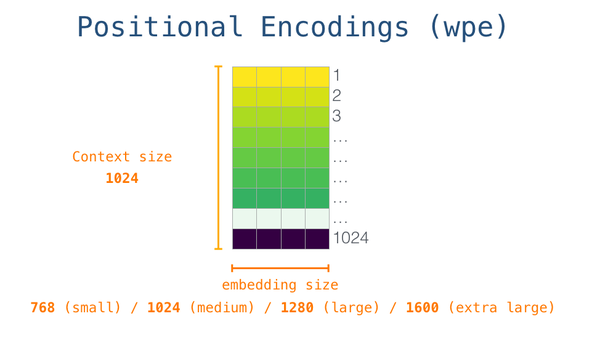

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/gpt2-positional-encoding.png', 600)

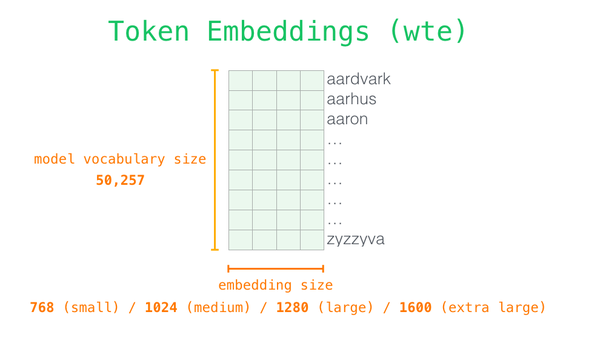

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/gpt2-token-embeddings-wte-2.png', 600)

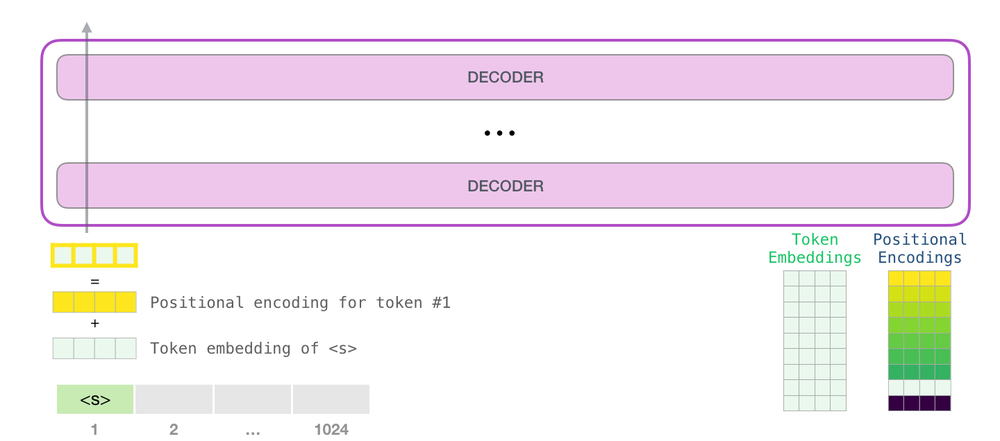

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/gpt2-input-embedding-positional-encoding-3.png', 1000)

In [ ]:
import copy
import torch
import torch.nn as nn

# https://github.com/graykode/gpt-2-Pytorch/blob/train/GPT2/model.py
class GPT2Model(nn.Module):
    def __init__(self, config):
        super(GPT2Model, self).__init__()

        # see config comments above to see meanings for these params
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.n_positions, config.n_embd)
        block = Block(config.n_ctx, config, scale=True)
        self.h = nn.ModuleList([copy.deepcopy(block) for _ in range(config.n_layer)])
        self.ln_f = LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)

    # input_ids = (bs, num word ids)
    # important to note that in first iteration:
    # input_ids is all mapped ids from sample text, but each following iteration will only contain the newly generated ids
    # past will contain attention key/values for previous tokens. see Attention class later for more details...
    def forward(self, input_ids, position_ids=None, token_type_ids=None, past=None):
        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = past[0][0].size(-2)
        if position_ids is None:
            # >> torch.arange(1, 4)
            # tensor([ 1,  2,  3])
            position_ids = torch.arange(past_length, input_ids.size(-1) + past_length, dtype=torch.long,
                                        device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_ids.size(-1))
        position_ids = position_ids.view(-1, position_ids.size(-1))

        inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        hidden_states = inputs_embeds + position_embeds
        # print('GPT2Model: input_ids: ', input_ids.shape)
        # print('GPT2Model: hidden_states: ', hidden_states.shape)

        presents = []
        for block, layer_past in zip(self.h, past):
          hidden_states, present = block(hidden_states, layer_past)
          presents.append(present)
        hidden_states = self.ln_f(hidden_states)
        output_shape = input_shape + (hidden_states.size(-1),)
        # print('GPT2Model: hidden_states: ', hidden_states.shape)
        # print('GPT2Model: output_shape: ', output_shape)

        return hidden_states.view(*output_shape), presents


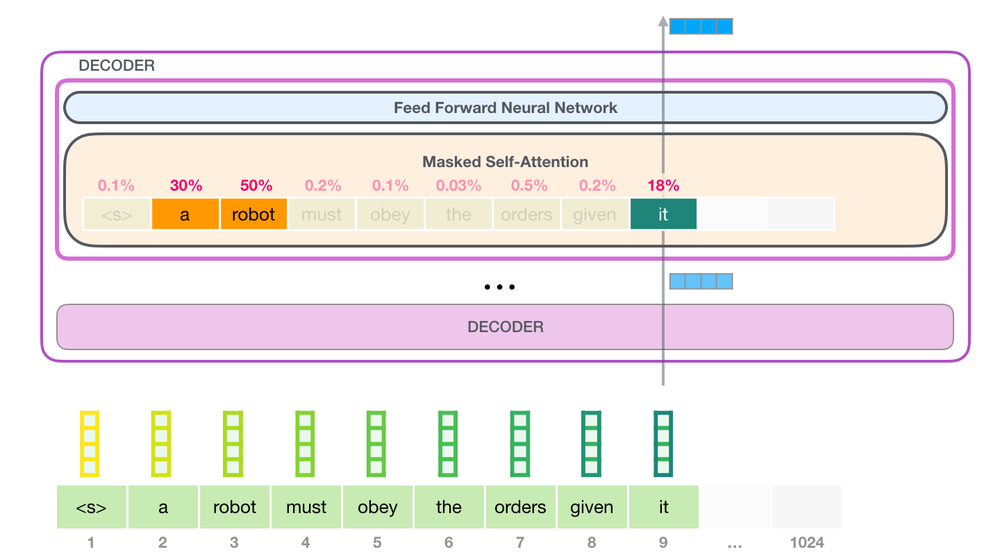

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/gpt2-self-attention-example-2.png', 1000)

In [ ]:
# https://github.com/graykode/gpt-2-Pytorch/blob/train/GPT2/model.py
class Block(nn.Module):
    def __init__(self, n_ctx, config, scale=False):
        super(Block, self).__init__()
        nx = config.n_embd
        self.ln_1 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.attn = Attention(nx, n_ctx, config, scale)
        self.ln_2 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        # MLP = Feed Forward Network
        self.mlp = MLP(4 * nx, config)

    def forward(self, x, layer_past=None):
        a, present = self.attn(self.ln_1(x), layer_past=layer_past)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x, present

class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias


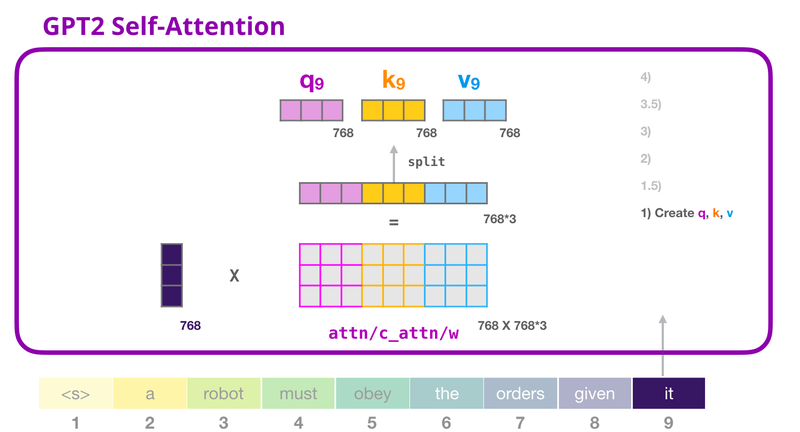

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/gpt2-self-attention-3.png', 800)

* **Query:** The query is a representation of the current word used to score against all the other words (using their keys). We only care about the query of the token we’re currently processing.
* **Key:** Key vectors are like labels for all the words in the segment. They’re what we match against in our search for relevant words.
* **Value:** Value vectors are actual word representations, once we’ve scored how relevant each word is, these are the values we add up to represent the current word.

A crude analogy is to think of it like searching through a filing cabinet. The query is like a sticky note with the topic you’re researching. The keys are like the labels of the folders inside the cabinet. When you match the tag with a sticky note, we take out the contents of that folder, these contents are the value vector. Except you’re not only looking for one value, but a blend of values from a blend of folders.

Multiplying the query vector by each key vector produces a score for each folder (technically: dot product followed by softmax).

We multiply each value by its score and sum up – resulting in our self-attention outcome.

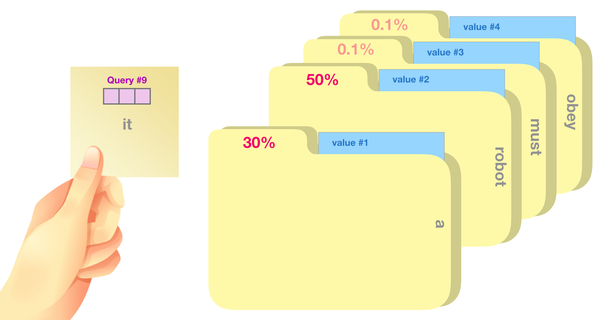

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/self-attention-example-folders-scores-3.png', 600)

In matrix form, we calculate the scores by multiplying a queries matrix by a keys matrix. Let’s visualize it as follows, except instead of the word, there would be the query (or key) vector associated with that word in that cell:

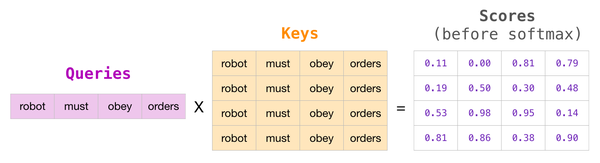

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/queries-keys-attention-mask.png', 600)

After the multiplication, we slap on our attention mask triangle. It set the cells we want to mask to -infinity or a very large negative number (e.g. -1 billion in GPT2):

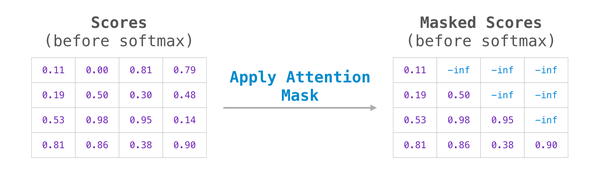

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/transformer-attention-mask.png', 600)

Then, applying softmax on each row produces the actual scores we use for self-attention:

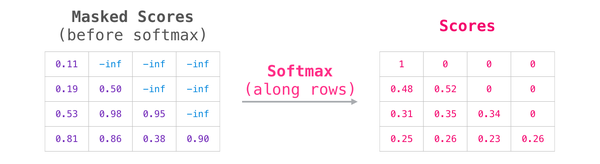

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/transformer-attention-masked-scores-softmax.png', 600)

In [ ]:
import math
from torch.nn.parameter import Parameter

# https://github.com/graykode/gpt-2-Pytorch/blob/train/GPT2/model.py
class Attention(nn.Module):
    def __init__(self, nx, n_ctx, config, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = config.n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, nx)
        self.c_proj = Conv1D(n_state, nx)

    def forward(self, x, layer_past=None):
        # x = torch.Size([batch_size, num_tokens, 768*3])
        x = self.c_attn(x)
        # print('Attention.forward: x.shape: ', x.shape)
        query, key, value = x.split(self.split_size, dim=2)
        query = self.split_heads(query)
        key = self.split_heads(key, k=True)
        value = self.split_heads(value)

        if layer_past is not None:
            past_key, past_value = layer_past[0].transpose(-2, -1), layer_past[1]  # transpose back cf below
            # num_tokens would be 1 in this if condition. layer_past would be all the past tokens already processed
            key = torch.cat((past_key, key), dim=-1)
            value = torch.cat((past_value, value), dim=-2)

        present = torch.stack((key.transpose(-2, -1), value))  # transpose to have same shapes for stacking
        a = self._attn(query, key, value)
        a = self.merge_heads(a)
        a = self.c_proj(a)
        return a, present
    
    def _attn(self, q, k, v):
        # [batch, head=12, num_tokens, embedding=64] * [batch, head=12, embedding=64, past_tokens + num_tokens]
        # w = [batch, head=12, num_tokens, past_tokens + num_tokens]
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))
        nd, ns = w.size(-2), w.size(-1)
        # bias here is to apply token masking as described above...
        b = self.bias[:, :, ns-nd:ns, :ns]
        w = w * b - 1e10 * (1 - b)
        w = nn.Softmax(dim=-1)(w)
        # [batch, head=12, num_tokens, past_tokens + num_tokens] * [batch, head=12, past_tokens + num_tokens, embedding=64]
        # = [batch, head=12, num_tokens, embedding=64]
        return torch.matmul(w, v)
      
    def split_heads(self, x, k=False):
        # x = torch.Size([batch_size, num_tokens, 768])
        # new_x_shape = [batch_size, num_tokens] + (12, 768 // 12 = 64)
        # new_x_shape = [batch_size, num_tokens, num_head=12, embedding_size=64)
        new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
        x = x.view(*new_x_shape)  # in Tensorflow implem: fct split_states
        if k:
            return x.permute(0, 2, 3, 1)  # (batch, head, head_features, seq_length)
        else:
            return x.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)
    
    def merge_heads(self, x):
        # from [batch, head=12, num_tokens, embedding=64]
        # to [batch, num_tokens, head=12, embedding=64]
        x = x.permute(0, 2, 1, 3).contiguous()
        # new_x_shape = [batch, num_tokens] + (12*64=768)
        new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_x_shape)  # in Tensorflow implem: fct merge_states

class Conv1D(nn.Module):
    def __init__(self, nf, nx):
        super(Conv1D, self).__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = Parameter(w)
        self.bias = Parameter(torch.zeros(nf))

    def forward(self, x):
        # size_out = torch.Size([batch_size, num_tokens]) + (768) = torch.Size([batch_size, num_tokens, 768*3])
        size_out = x.size()[:-1] + (self.nf,)
        # print(x.size(), x.size()[:-1], size_out)

        # addmm(a, b, c) = matrix mult (b, c) + bias (a)
        # [num_tokens, 768] * [768, 768*3] + [768*3]
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        # torch.Size([batch_size, num_tokens, 768*3])
        x = x.view(*size_out)
        return x

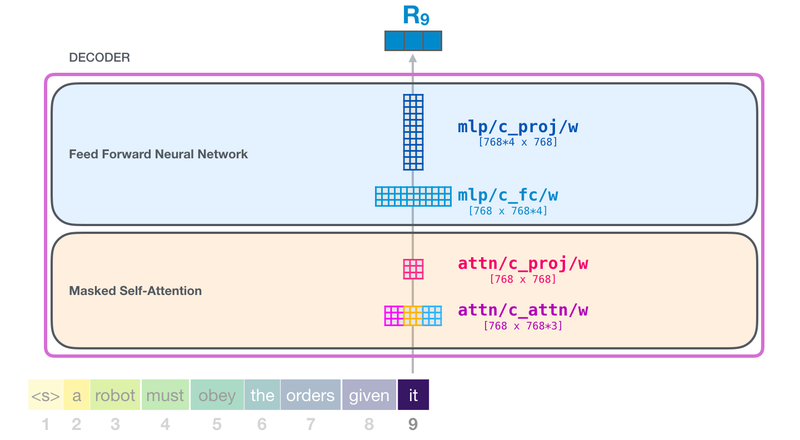

In [ ]:
showImage('/content/gdrive/My Drive/development/ai/5-gpt2/readme/gpt2-transformer-block-weights-2.png', 800)

In [ ]:
# https://github.com/graykode/gpt-2-Pytorch/blob/train/GPT2/model.py
# MLP = Feed Forward Network
class MLP(nn.Module):
    def __init__(self, n_state, config):  # in MLP: n_state=3072 (4 * n_embd)
        super(MLP, self).__init__()
        nx = config.n_embd
        # fc = (nx,n_state)
        self.c_fc = Conv1D(n_state, nx)
        # proj = (n_state,nx)
        self.c_proj = Conv1D(nx, n_state)
        # activation function
        self.act = gelu

    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        return h2

def gelu(x):
    # https://datascience.stackexchange.com/questions/49522/what-is-gelu-activation
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


In [ ]:
# https://github.com/graykode/gpt-2-Pytorch/blob/train/GPT2/model.py
class GPT2LMHeadModel(nn.Module):
    def __init__(self, config):
        super(GPT2LMHeadModel, self).__init__()
        self.transformer = GPT2Model(config)
        self.lm_head = GPT2LMHead(self.transformer.wte.weight, config)
    
    def set_tied(self):
        """ Make sure we are sharing the embeddings
        """
        self.lm_head.set_embeddings_weights(self.transformer.wte.weight)

    def forward(self, input_ids, position_ids=None, token_type_ids=None, lm_labels=None, past=None):
        hidden_states, presents = self.transformer(input_ids, position_ids, token_type_ids, past)
        lm_logits = self.lm_head(hidden_states)

        # if training, then we have the expected outputs... lets calculate the loss
        if lm_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            # print('lm_logits.shape: ', lm_logits.shape, 'lm_labels.shape: ', lm_labels.shape)
            # lm_logits.shape: torch.Size([1, 1023, 50257]) 
            # lm_labels.shape:  torch.Size([1, 1023])
            loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), lm_labels.contiguous().view(-1))
            return loss

        return lm_logits, presents


class GPT2LMHead(nn.Module):
    def __init__(self, model_embeddings_weights, config):
        super(GPT2LMHead, self).__init__()
        self.n_embd = config.n_embd
        self.set_embeddings_weights(model_embeddings_weights)

    def set_embeddings_weights(self, model_embeddings_weights):
        # torch.Size([50257, 768])
        embed_shape = model_embeddings_weights.shape

        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        # the learnable weights of the module of shape (out_features, in_features)
        # in = 768 embed_size, out = 50257 vocab_size
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, hidden_state):
        # Truncated Language modeling logits (we remove the last token)
        # h_trunc = h[:, :-1].contiguous().view(-1, self.n_embd)
        lm_logits = self.decoder(hidden_state)
        return lm_logits

**Lets test the generator!**

In [ ]:
def load_weight(model, state_dict):
    old_keys = []
    new_keys = []
    for key in state_dict.keys():
        new_key = None
        if key.endswith(".g"):
            new_key = key[:-2] + ".weight"
        elif key.endswith(".b"):
            new_key = key[:-2] + ".bias"
        elif key.endswith(".w"):
            new_key = key[:-2] + ".weight"
        if new_key:
            old_keys.append(key)
            new_keys.append(new_key)
    for old_key, new_key in zip(old_keys, new_keys):
        state_dict[new_key] = state_dict.pop(old_key)

    missing_keys = []
    unexpected_keys = []
    error_msgs = []
    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, "_metadata", None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    def load(module, prefix=""):
        local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
        module._load_from_state_dict(
            state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs
        )
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + ".")

    start_model = model
    if hasattr(model, "transformer") and all(not s.startswith('transformer.') for s in state_dict.keys()):
        start_model = model.transformer
    load(start_model, prefix="")

    # Make sure we are still sharing the output and input embeddings after loading weights
    model.set_tied()
    return model

In [ ]:
import random
import numpy as np
from tqdm import trange
import torch.nn.functional as F

# https://github.com/graykode/gpt-2-Pytorch/blob/train/GPT2/sample.py
def sample_sequence(model, length, start_token=None, batch_size=None, context=None, temperature=1, top_k=0,
                    device='cuda', sample=True):
    if start_token is None:
        assert context is not None, 'Specify exactly one of start_token and context!'
        context = torch.tensor(context, device=device, dtype=torch.long).unsqueeze(0).repeat(batch_size, 1)
    else:
        assert context is None, 'Specify exactly one of start_token and context!'
        context = torch.full((batch_size, 1), start_token, device=device, dtype=torch.long)

    prev = context
    output = context
    past = None

    with torch.no_grad():
        for i in trange(length):
            logits, past = model(prev, past=past)
            # torch.Size([1, num_tokens, 50257])
            logits = logits[:, -1, :] / temperature
            logits = top_k_logits(logits, k=top_k)
            log_probs = F.softmax(logits, dim=-1)

            if sample:
                prev = torch.multinomial(log_probs, num_samples=1)
            else:
                # Returns the k largest elements of the given input tensor along a given dimension.
                _, prev = torch.topk(log_probs, k=1, dim=-1)
    
            output = torch.cat((output, prev), dim=1)
    return output

def top_k_logits(logits, k):
    if k == 0:
        return logits

    # If dim is not given, the last dimension of the input is chosen.
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]
    return torch.where(logits < min_values, torch.ones_like(logits, dtype=logits.dtype) * -1e10, logits)

# https://github.com/graykode/gpt-2-Pytorch/blob/train/main.py
def text_generator(args, state_dict, config):
    seed = random.randint(0, 2147483647)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load Model
    enc = get_encoder()
    model = GPT2LMHeadModel(config)
    model = load_weight(model, state_dict)
    model.to(device)
    model.eval()

    # n_ctx is the maximum number of token in an input sequence
    if args['length'] == -1:
        args['length'] = config.n_ctx // 2
    elif args['length'] > config.n_ctx:
        raise ValueError("Can't get samples longer than window size: %s" % config.n_ctx)

    print(args['text'])
    context_tokens = enc.encode(args['text'])
    print(context_tokens)

    generated = 0
    for _ in range(args['nsamples'] // args['batch_size']):
        out = sample_sequence(
            model=model, length=args['length'],
            context=context_tokens, # if not args.unconditional else None,
            # start_token=enc.encoder['<|endoftext|>'] if args.unconditional else None,
            batch_size=args['batch_size']
        )
        out = out[:, len(context_tokens):].tolist()
        print(out)
        for i in range(args['batch_size']):
            generated += 1
            text = enc.decode(out[i])
            if args['quiet'] is False:
                print("=" * 40 + " SAMPLE " + str(generated) + " " + "=" * 40)
            print(args['text'])
            print(text)



In [ ]:
%%bash
mkdir -p pretrained_models/117M
# curl --output pretrained_models/117M/model.bin https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-pytorch_model.bin
cp "/content/gdrive/My Drive/development/ai/5-gpt2/pretrained/gpt2-pytorch_model.bin" ./pretrained_models/117M/

In [ ]:
import os

model_name = '117M'
model_path = os.path.join('pretrained_models', model_name, 'model.bin')

args = {
    'text': "It was a bright cold day in April, ",
    'nsamples': 1,
    'batch_size': 1,
    'length': -1,
    # 'length': 2,
    'quiet': False
}

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location='cpu' if not torch.cuda.is_available() else None)
    text_generator(args, state_dict, GPT2_117M_Config())

  0%|          | 0/512 [00:00<?, ?it/s]

It was a bright cold day in April, 
[1026, 373, 257, 6016, 4692, 1110, 287, 3035, 11, 220]


100%|██████████| 512/512 [00:09<00:00, 54.44it/s]

[[3711, 8566, 319, 262, 256, 1127, 286, 257, 4077, 7309, 1660, 4346, 9951, 612, 287, 257, 2344, 12135, 13, 383, 3933, 12, 1941, 12, 727, 531, 339, 373, 42282, 416, 262, 33674, 265, 1522, 20209, 7880, 11, 706, 257, 640, 736, 379, 3047, 11, 618, 262, 20209, 9617, 530, 1588, 10242, 1208, 379, 736, 9055, 8616, 338, 2366, 981, 9644, 257, 33157, 329, 379, 1551, 2681, 5695, 13, 198, 198, 13710, 4844, 286, 262, 10245, 319, 262, 7691, 6, 5504, 287, 543, 9181, 9238, 2993, 340, 373, 8832, 5648, 1360, 338, 4238, 1502, 286, 1597, 13, 383, 12747, 260, 415, 3382, 284, 910, 1365, 621, 326, 373, 1744, 13, 198, 198, 1639, 1807, 428, 373, 257, 407, 12, 568, 12, 7266, 7100, 12, 4360, 12, 86, 9790, 1502, 30, 198, 198, 1026, 318, 13, 198, 198, 1870, 645, 530, 338, 8046, 379, 262, 640, 13, 3862, 318, 18824, 13, 3825, 7588, 290, 665, 9235, 781, 10381, 656, 10747, 11, 3599, 510, 7523, 329, 262, 4252, 13, 1629, 530, 966, 262, 2646, 48127, 1872, 520, 282, 21141, 1444, 366, 35, 282, 1122, 4373, 526, 12074, 2702, 

**Training**


In [ ]:
%%bash
mkdir -p ./dataset
# wget -P ./dataset/ https://raw.githubusercontent.com/priya-dwivedi/Deep-Learning/master/GPT2-HarryPotter-Training/data_cleanup/output_cleaned.txt
cp "/content/gdrive/My Drive/development/ai/5-gpt2/dataset/harry_potter_cleaned.txt" ./dataset/

In [ ]:
# https://github.com/graykode/gpt-2-Pytorch/blob/train/GPT2/data.py
def load_dataset(enc, path, combine):
    paths = []

    for (dirpath, _, fnames) in os.walk(path):
        for fname in fnames:
            paths.append(os.path.join(dirpath, fname))
    # filter paths
    paths = [p for p in paths if '.DS_Store' not in p]

    token_chunks = []
    raw_text = ''
    for path in tqdm.tqdm(paths):
        # Plain text
        with open(path, mode='r', encoding='utf-8') as fp:
            raw_text += fp.read()

        if len(raw_text) >= combine:
            tokens = np.stack(enc.encode(raw_text))
            token_chunks.append(tokens)
            raw_text = ''
        else:
            raw_text += '<|endoftext|>'

    if raw_text:
        tokens = np.stack(enc.encode(raw_text))
        token_chunks.append(tokens)
        
    return token_chunks

class Sampler(object):
    """Fairly samples a slice from a set of variable sized chunks.
    'Fairly' means that the distribution is the same as sampling from one concatenated chunk,
    but without crossing chunk boundaries."""

    def __init__(self, chunks, seed=None):
        self.chunks = chunks
        self.total_size = sum(chunk.shape[0] for chunk in chunks)
        # boundaries are the chunk sizes
        self.boundaries = [0]
        for i in range(len(chunks)):
            self.boundaries.append(self.boundaries[-1] + chunks[i].shape[0])
        self.rs = np.random.RandomState(seed=seed)

    def sample(self, length):
        assert length < self.total_size // len(self.chunks), "Dataset files are too small to sample {} tokens at a time".format(length)

        while True:
            index = self.rs.randint(0, self.total_size - length - 1)

            # i = boundary that index is in
            i = binary_search(lambda j: self.boundaries[j] > index, 0, len(self.boundaries) - 1) - 1

            # sample length fits within the chunk at the starting index in that chunk
            if self.boundaries[i + 1] > index + length:
                # finding start of boundary from index
                within_chunk = index - self.boundaries[i]
                return self.chunks[i][within_chunk: within_chunk + length]

def binary_search(f, lo, hi):
    if f(lo) or not f(hi):
        return None
    while hi > lo + 1:
        mid = (lo + hi) // 2
        if f(mid):
            hi = mid
        else:
            lo = mid
    return hi

In [ ]:
import time
import tqdm

# https://github.com/graykode/gpt-2-Pytorch/blob/train/train.py
BASE_DIR = '/content/gdrive/My Drive/development/ai/5-gpt2/'
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoint')
SAMPLE_DIR = os.path.join(BASE_DIR, 'samples')

def get_state_dict(model_name='117M'):
    model_path = os.path.join('pretrained_models', model_name, 'model.bin')
    return torch.load(model_path, map_location='cpu' if not torch.cuda.is_available() else None)

def load_model(model, state_dict, device):
    model = load_weight(model, state_dict)
    model.to(device)
    return model

def get_latest_ckpt(ckpt_run_dir):
    if not os.path.isdir(ckpt_run_dir):
        return None

    ckpts = [ckpt for ckpt in os.listdir(ckpt_run_dir) if ckpt.endswith('.tar')]
    if len(ckpts) == 0:
        return None

    ckpts = [(ckpt, int(ckpt.split('.')[0].split('-')[1])) for ckpt in ckpts]
    ckpt, counter = max(ckpts, key=lambda tup: tup[1])
    ckpt_path = os.path.join(ckpt_run_dir, ckpt)
    return ckpt_path

def train(args):
    enc = get_encoder()
    config = GPT2_117M_Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GPT2LMHeadModel(config)

    # error checking
    if args['sample_length'] > config.n_ctx:
        raise ValueError("Can't get samples longer than window size: %s" % config.n_ctx)

    # select variables to update while training
    all_vars = [tensor for tensor in model.parameters()]
    transformer_vars = [tensor for name, tensor in model.named_parameters() if 'transformer.h.' in name]
    train_vars = transformer_vars if args['only_train_transformer_layers'] else all_vars

    # create optimizer
    if args['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(train_vars, lr=args['learning_rate'])
    # elif args.optimizer == 'sgd':
    else:
        optimizer = torch.optim.SGD(train_vars, lr=args['learning_rate'])

    # load model
    ckpt_path = get_latest_ckpt(os.path.join(CHECKPOINT_DIR, args['run_name']))
    if ckpt_path is None:
        state_dict = get_state_dict(args['model_name'])
        model = load_model(model, state_dict, device)
        counter = 1
    else:
        print(ckpt_path)
        ckpt = torch.load(ckpt_path)
        model = load_model(model, ckpt['model_state_dict'], device)
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        counter = ckpt['counter']
    
    # load datasets
    print('load training dataset...')
    chunks = load_dataset(enc, args['dataset'], args['combine'])
    data_sampler = Sampler(chunks)
    print('dataset has {} tokens'.format(data_sampler.total_size))

    def save():
        os.makedirs(os.path.join(CHECKPOINT_DIR, args['run_name']), exist_ok=True)
        save_path = os.path.join(CHECKPOINT_DIR, args['run_name'], 'ckpt-{}.tar'.format(counter))
        torch.save({
            'counter': counter,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
        
    def generate_samples():
        """Generate unconditional samples."""
        print('Generating samples...')

        generated = 0
        all_text = []

        for _ in range(args['sample_num']):
            out = sample_sequence(
                model=model, length=args['sample_length'], context=None,
                start_token=enc.encoder['<|endoftext|>'], batch_size=1,
                temperature=1.0, top_k=args['top_k'], device=device
            )

            out = out[:, :].tolist()[0]
            generated += 1
            text = enc.decode(out)
            print("=" * 40 + " SAMPLE " + str(generated) + " " + "=" * 40)
            print(text)
            all_text.append(text)

        os.makedirs(os.path.join(SAMPLE_DIR, args['run_name']), exist_ok=True)
        with open(os.path.join(SAMPLE_DIR, args['run_name'], 'samples-{}.txt'.format(counter)), 'w') as fp:
            fp.write('\n'.join(all_text))
    
    def sample_batch():
        return torch.tensor([data_sampler.sample(1024) for _ in range(args['batch_size'])])

    avg_loss = (0.0, 0.0)
    start_time = time.time()

    while True:
        if counter % args['save_every'] == 0:
            save()
        if counter % args['sample_every'] == 0:
            generate_samples()

        optimizer.zero_grad()
        batch = sample_batch()
        loss = model(batch[:, :-1].to(device), lm_labels=batch[:, 1:].to(device))
        loss.backward()
        optimizer.step()

        avg_loss = (avg_loss[0] * 0.99 + loss, avg_loss[1] * 0.99 + 1.0)

        print('[{counter} | {time:2.2f}] loss={loss:2.2f} avg={avg:2.2f}'
              .format(counter=counter, time=time.time() - start_time,
                      loss=loss, avg=avg_loss[0] / avg_loss[1]))

        counter += 1

In [ ]:
args = {
    'model_name': '117M',
    'run_name': 'harrypotter',
    'optimizer': 'adam',
    'only_train_transformer_layers': False,
    'save_every': 1000,
    'learning_rate': 0.00002,
    'batch_size': 1,
    'dataset': 'dataset',
    # Concatenate input files with <|endoftext|> separator into chunks of this minimum size
    'combine': 50000,
    'sample_every': 100,
    'sample_num': 1,
    'sample_length': 1023,
    'top_k': 40
}

train(args)

/content/gdrive/My Drive/development/ai/5-gpt2/checkpoint/harrypotter/ckpt-12000.tar


  0%|          | 0/5 [00:00<?, ?it/s]

load training dataset...


100%|██████████| 5/5 [00:16<00:00,  3.38s/it]


dataset has 3929075 tokens


  0%|          | 4/1023 [00:00<00:25, 39.39it/s]

Generating samples...


100%|██████████| 1023/1023 [00:23<00:00, 44.04it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“It can’t be that — Petunia, did you hear about Hagrid?”
Hagrid seemed very taken aback. He obviously thought Harry
was connected with Hagrid. Harry looked away from him,
and thought only of Hagrid and what he had done to his
own house. When he arrived in the hospital wing, it
was Hagrid who was greeted with the most stunned
look of anyone.”
Harry turned to Professor Trelawney.
“So that’s what she’s saying,” said Harry.
“What’s up with her?”
“She’s been in here a bit,” said Hagrid. “One of the
others told her to come in. Look at the curtains — ”
“This makes no sense!” Harry yelled. “Now what’re you
stubborn boy wants to do this year?”
“Watching people’s faces while they’re
comparing needles,” said Hagrid, shifting his chair slightly so
the next two tables can fit him. “I’m in a lot of trouble
for having touched a wand!” There was a jolt of disgust in
Hagrid ’s voice. “I’m not trying 

  1%|          | 6/1023 [00:00<00:18, 53.71it/s]

[12099 | 85.48] loss=1.00 avg=0.85
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 54.64it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“I thought I — ”
“Well — you know — ” Hermione stopped
almost instantly.
“What did Uncle Vernon do on April Fools’ day
walked into your room three times in a row?”
“Thirteen each in the morning!” said Harry. “And that was
after you and Dobby had escaped!”
“How could he?” said Hermione, aghast.
 
Harry Potter and the Goblet of Fire - J.K. Rowling
“Because they tried to stop him from murdering
his best student,” said Harry. “And because they
liked him so much, because he had helped — ”
“HOWEVER,” said Hermione again, very loudly. “I
surely not — I’m not sure you’ve heard the point
about — ”
“Yes, he has,” said Harry slowly. “But Dobby and Harry
were friends, and when they sneaked up my door every
other week to look after my three best friends — ”
“Then that means that they sneaked up yours,” said
Hermione sharply.
“Of course I haven’t,” said Harry bitterly, “and Dobby and
Harry were fr

  1%|          | 6/1023 [00:00<00:17, 59.51it/s]

[12199 | 144.36] loss=0.87 avg=0.87
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 55.81it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>In other news, Potter —
Professor McGonagall’s not teaching anymore!”
It was a common saying in Hogwarts: If you can’t stand
something, you never know when its replacement will be
obvious.
Professor McGonagall gave another interview on the same program
every few months, this time asking the students to list
their favorite Quidditch players and their names
at the start of the next lesson.
“Very well,” said Professor McGonagall briskly, folding up
her parchment and dropping it onto a teacher’s table
before each of the four players. “I’ll ask you all to list how
you’ve changed the players’ names so far this term — ”
 
“Harry!” Hermione said in a sudden
voiceover to distinguish herself. “I’ve had Professor Binns
— Fleur — — go on, boy — and — ”
Fleur Fletcher, who had been practicing owls by
firelight, now spelled Hedwig, came up to congratulate
Harry on his Gryffindor Quidditch win.
“It

  1%|          | 6/1023 [00:00<00:18, 54.05it/s]

[12299 | 202.85] loss=0.84 avg=0.85
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 55.33it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>says,‘which is to say, a great
amount of both,”” he said, his eye glinting. “You
know, OmniSort conjures people who are very
good at what they are doing; I would think she
sends them all a decent deal of stuff, but no — ”
“That’s right,” said Buckbeak. He tried to point
“Cleansing Cream,” but stopped too, as he caught
a glimpse of Violet of the Seeker’s Day party, and their
“Cleansing Cream,” retorted Harry.
“We should try and get ahold of Viktor, just in case,”
said Buckbeak. “Remember, Viktor hasn’t got a bed,
Has he?”
 
They scowled at him.
Buckbeak tapped his nose and shrugged.
“Very well,” said Harry.
He was going to go and buy some Seaweed.
Buckbeak looked quite angry.
“Let’s go,” he said. “Come on, OmniSort — ”
Harry left, and there was no reply from Buckbeak
until he reached the door.
“Where ’re you going?” Harry asked him.
Buckbeak hesitated, then pointed his wand at
him.
“H

  1%|          | 7/1023 [00:00<00:17, 59.06it/s]

[12399 | 261.52] loss=1.20 avg=0.84
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.40it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“It’s got to be good,” Harry muttered, his heart pounding as though it was bound to stop him from saying it.
“Harry — you asked for my thanks,” said Dumbledore,
staring at Harry, who was shaking with sudden happiness,
“the very gratitude — ”
Dumbledore had put a hand on Harry’s shoulder, he
could have squeezed it, but he squeezed it very hard. Dumbledore
gripped his arm and turned to face Harry, his face hidden
in the shadows.
“W-what?” he gasped.
“W-what is it?” said Dumbledore, still wearing the
smirk that had worn so tightly on his chin. “Harry
— Sirius — have you seen him?”
“AUDIE!” he gasped. “Yes — I — I was asking you to
forgive me — ”
As Dumbledore continued to stare into his blank, white
space, Harry felt Riddle come alive. He writhed and
wailed, the way his feet had struck his now immovable
ground, then, suddenly, with horrific force, the
man on the ground beneath him came 

  1%|          | 6/1023 [00:00<00:17, 57.33it/s]

[12499 | 319.83] loss=0.65 avg=0.86
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 55.34it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“Mum, don’t!”
“And you can’t blame her!” said Ginny. “If Marge had just
put up a good fight, we’d be going to the Snitch for her!
And you know what? I bet we’ll get to it!”
Hermione laughed, but Hermione didn’t turn up for work, and
then Ron told the Weasley twins what he’d said.
 
“Why aren’t you going to lunch?” said Ron brightly. “Are
you hungry?”
Harry and Hermione both said no. When the story
first broke that Hermione had told Dudley about the
little green dinosaur he’d brought home for
cleaning, Harry and Hermione both jumped at the chance to
 read.
“Harry!” Hermione had her earplugs on. “How did you
know?”
“Hermione, we know you weren’t going to go, you know,”
said Harry. “Because your gran held you up as a
ball and he wanted to keep an eye on you.”
“Yeah, well, I couldn’t help it. They keep trying to
change the price points on food, but Mum wouldn’t
let them go so cheap. And 

  1%|          | 7/1023 [00:00<00:16, 60.44it/s]

[12599 | 378.50] loss=0.91 avg=0.90
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.35it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Professor Trelawney
was the smallest of Hermione’s three brothers.
“He’s already told me,” Ron said tensely to Harry,
who was looking around at Ron’s guilty face.
“He’s taken Hermione’s copy of the Daily Prophet and
started poking holes in it. If he founds out how to do
the spells he’d told me about three months ago, he’d
be expelled.”
“How on earth d’you think Dumbledore ’s going
to get rid of him when he knows so little magic
male students can get — ”
Ron beamed at Harry. He wanted to cheer Ron up,
but he was planning to ask, “Did you really say
that to Wormtail?”
 
Hermione hesitated, then said, “Yeah — I suppose
it’s very unlikely one day we’ll find out how to do
them. But if they hadn’t found out how to get past
Lockhart, I’d still be mad. ... Maybe if Harry’s learned
a Daily Prophet lesson a day, the rest of you
‘Don’t cry,’ should concentrate instead on growing
more powerful. 

  1%|          | 6/1023 [00:00<00:17, 59.39it/s]

[12699 | 436.85] loss=0.86 avg=0.85
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.73it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>to be a very great thing at Hogwarts
for the last fifty years. I say great, but not good enough
to match Hogwarts with you, Harry. You’re not ready,
but you’re looking pretty good.”
Hagrid’s voice suddenly sounded hoarse. He took a
while to calm down, then stopped. Harry looked at him,
trying to find the silence to quiet him down.
The moment he had entered it had gone horribly wrong.
For one thing, Madam Pomfrey had forced Hagrid’s
head into the fireplace, which had started a loud,
silly firework cycle. She had then started adding more
flames, which had started a series of small fireworks
that illuminated the distant castle walls. For a few seconds,
then just the thought of more flames caused Harry
and the flames dramatically to go up. Hagrid was gone, but
the Dursleys had done nothing with Harry, whether
afternoon tea or a stroll through the grounds.
Nevertheless, Harry had met othe

  1%|          | 6/1023 [00:00<00:17, 57.81it/s]

[12799 | 495.07] loss=0.80 avg=0.84
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 56.93it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“That’s more like it!” Ron yelled, waving Harry up and down as he made his way up to the
broom — the first one down! The one Harry barely missed —
“What’s up, Harry? You don’t want to run into Hagrid, do
you?”
Harry didn’t answer. He walked for what seemed like
one long, deep, shuddering minute.
“Hagrid,” he mumbled, “I want to know why you didn’t
stop there. Tell me why you didn’t stop him.”
It was a stupid question. After all, what did
Dumbledore know about Ron, what Hagrid said only
sorted into Ron’s head, anyway? But how many
masters had he had at his disposal, either?
 
Harry Potter and the Goblet of Fire - J.K. Rowling
THE PARTING OF THE WAYS
“There are some amazing things that have happened
over the years at Hogwarts that I find very boring. But
never mind this, I will never know about the others. I
must go back to school and see what Mum and Dad
have forgotten to think about.

  1%|          | 6/1023 [00:00<00:17, 58.80it/s]

[12899 | 553.21] loss=0.88 avg=0.81
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.07it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“It’s an orphan,” she said as Harry, Ron, Fred, and Gilderoy swung up the
Invisibility Cloak, Fleur Delacour tucked an
eagle under her arm, and they left the cave, not
glimmering too much; their footsteps were getting louder
for it now. “There’s a way’s out, isn’t there?” Harry had heard
Fleur Delacour make a hurried diversion, and
Dumbledore ’s car was now floating above the car.
“And we can’t go that far without help from
Slytherin,” said Dumbledore. “We’ll have to come
along and help you. ...”
“I think,” said Harry, “that this is all very silly, and
perhaps too easy a tale to sell — Fleur keeps dying
off and on, and everyone’s lost at the sight of a
tiny creature, and it hardly ever gets a second sniff
from the Malfoys.”
“A second sniff?” said Dumbledore, and Fleur began
to shriek. “A second sniff! What did they think we
made of the Weasleys?”
“We won’t carry Fleur on my back as a

  1%|          | 6/1023 [00:00<00:18, 54.43it/s]

Generating samples...


100%|██████████| 1023/1023 [00:21<00:00, 48.01it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>...I had the whole family and I accompanied him, too,” Snape said. “This must be great.”
“Very pretty, isn’t it?” said Harry
reproachingly, leaning toward Snape even more.
“The best pair of them, they’re the best pair of
Harry’s dreams.”
“You’re in four — three really,” said Snape, in an
almost frightened whisper.
 
Harry Potter and the Goblet of Fire - J.K. Rowling
“It’s a double benefit,” said Harry darkly. “One,
your dreams, so I can’t really manage them, two,
they help keep me company long enough to polish your
escaping old Faith, Miss.”
Snape ’s eyebrows had gone razor sharp.
“Harry,” said Harry firmly, “I want to see you fit, I
expect?”
“I can wait.”
The last thing Harry wanted was for Snape to say
something that had the potential to shake his head at
Hermione and lead to anything else in the next few
minutes.
“All right, Harry?” said Snape just as fast as he could.
“Shhh, coug

  1%|          | 6/1023 [00:00<00:17, 58.30it/s]

[13099 | 681.72] loss=0.92 avg=0.79
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 56.99it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Hermione was staring out the window of her
miniature house, apparently
unprepared and unafraid to flinch at the sight
of anything that might embarrass her. However,
she was getting slightly more nervous.
“There’s no point going into town,” she said
thoughtfully. “There’s just not the willow in the willow
tree ... and I don’t know what that tree can do. ...”
She pulled a letter out of her pocket.
Dear Mum, “We know Rita Skeeter, but she
doesn’t seem to know how to talk to unicorns. I read
about her in Witch Weekly and Angel
Moms liked it so much.
I’ve been trying to find an owl for ages and
 
many subjects, but she (myself included) hasn’t lived up
to her wildest dreams. Is your essay useful? How can
you bring light back to the dead?
I’m stranded — you can send to Marvolo back to
him. He’s been up to visit me in the dead of night. I’m
sending him a pen and paper from home, but I haven

  1%|          | 6/1023 [00:00<00:17, 57.30it/s]

[13199 | 739.82] loss=0.79 avg=0.79
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.29it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>In spite of their growing popularity, the Irish National Liberation War suffered from severe over-reliance on the teabagging creatures. The guinea pig, a grotesque form of a sheep covered in thick, bristling tendrils, had to endure at least one attempted guinea pig escape in a single night. The unfortunate gallant Harry found himself bunched up next to on the edge of the enclosure, attempting to quash a Cree ant that had attempted to attack him. Only, this time it was the guinea pig who actually managed to kill him:
The Cree ant, however, didn’t seem keen to accept a stronger alternative. After an argument, the guinea pig agreed to join the Warrington and Woodruff Charitable Trust, but insisted on being part of the team. He was still very keen for more sheep to be chosen, but so the trust was dissolved, and Harry Potter returned to Hogwarts to find the school fully staffed.
 
The war

  1%|          | 7/1023 [00:00<00:16, 60.20it/s]

[13299 | 797.88] loss=0.43 avg=0.77
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.74it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>If you like this post, be sure to sign up for my e-books giveaway! Or you can follow me on twitter
and join my RSS feed for loads of other great stuff!
And here are a few other great stuff that Harry had to
read and answer some simple questions about himself and
Dudley!
You, too, might want to check out these QuickStart Books:
How to Disapparate Completely Free of Glaucoma for a Beginner
How to Disapparate for the Quickster who Would Rather
Were Alive to Disrupt a Highly Disrupting Underground Worm
How to Distract and Stun a Highly Disturbed Worm
How to Parrot a Stunned and Enraged Worm
How to Parrot a Worm Made Of Polyjuice Pots
How To Pull a Highly Disturbed Worm Back To Its Innate Foul Play-
Point Level
Which of your DUMBLEDORE WORDS have YOU ever WORM
ABOUTED an Abuse Of The System? Let us know in the comments
And, dear readers ... if you haven’t read The Complete
Book Of Spells 

  1%|          | 6/1023 [00:00<00:17, 58.94it/s]

[13399 | 855.74] loss=0.78 avg=0.76
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.36it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>The house-elf was quite small. Harry could just see a pale unicorn shadowing along the walls.
He was alone.
There were no children at the front of the house today.
The fires that open in the corridors normally are the
parents’ fires. But this time of year, there were
no baby owls guarding the front door, and the flames
gleaming the little unicorn, Harry realized, there was a
purpose in saving some of the fire dust before it burned off
himself.
“Well?” said Fred, pointing at the tiny fire that had
burned at the top of the garden this afternoon. “Shade it
with something good. I hate, ’cept a lipstick, so much
mist.”
 
Harry Potter and the Goblet of Fire - J.K. Rowling
“Good thinking,” said Fred, “do you know what that
tetra-red creature’s asked us to do, you know, to get
its very sharp?”
“Nah, it’s just used ... in case we need to — er, well, we
have no partners in nature.”
“That’s a w

  1%|          | 7/1023 [00:00<00:16, 60.83it/s]

[13499 | 913.76] loss=0.92 avg=0.75
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 58.42it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“It’s time to play,” Lupin breathed as the second
man pulled off his knitted top and walked away
without speaking (except to say, of course, that if it
was anyone but a parrot, Lupin wouldn’t have any
idea why he was being watched).
“I’ve done a number on masks,” Harry said after a
moment or so, and Lupin, too, was looking suspiciously
back on the field.
“I don’t blame you,” said Dumbledore shortly. “You
haven’t changed your mind about pretending to be
something else, have you?”
“No,” said Harry, “I still like my old masks,
and I wish I had at least once had this boy’s, ’cause
they’re very brave.”
 
“That old git, though?” said Dumbledore anxiously.
“How could you?”
“I’m sorry, Harry, but he couldn’t hurt you,
thanks in disguise. ...”
As Harry talked him through the masks, he
saw one thing clear: Dumbledore shaking his
breath once more, and nodding happily to Professor
McGonagall.
“L

  1%|          | 7/1023 [00:00<00:16, 60.79it/s]

[13599 | 971.44] loss=1.09 avg=0.72
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.39it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Darkness was still on
Hagrid’s face, though it was shining with
pain. He wasn’t in a happy mood, not when the
summer had seen him becoming the most
watched wizard of the new year. Nobody could
believe that he had stopped growing hair! And nobody
could they accept that Dumbledore had made a bit
of him. Nobody could.
Harry had been explaining this to Snape for some
time.
“It is a curse that Dark wizards here at Hogwarts have been
bothering for thirty years. Mr. Voldemort’s enemies . . .
 
many of them have been electronic trolls, who have
been moving into the castle to carry out the wishes of
the students here under the watch of Voldemort’s
enemies.”
Snape tried to break off again, but Harry forced
him to him again.
“And what have my own Dark friends done to me?”
“Laughed at when Voldemort turned up at the last
minute,” said Dumbledore. “You said they had
been around for Voldemort . . 

  1%|          | 6/1023 [00:00<00:17, 58.82it/s]

[13699 | 1029.46] loss=0.86 avg=0.77
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.58it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>There was a
footstep and a ruffling noise behind them as Ron
claused with all his might to make a last-ditch
doubt about whether to run. Harry and Crookshanks
stepped back into the compartment and looked around
all for a sign that another storm was abating — then,
Harry knew, they would have noticed, when it had
realized that the storm had started.
The storm beneath them had started to growl — the
chilly, cackling laughter it had
hesured as it heated up got blown out of them as
they hurried up the quiet lane, back into Dumbledore’s
office, and back toward the Slytherin table.
Dumbledore had obviously gone off the deep end with
something to say about Hermione. He got up, stretched,
turned on his large desk, and stood up, taking in
the latest model nine Ptw:
 
Malfoy had just driven in through a gap in the wall
between two portholes. Loud, shuffling feet were now
circling the blackboar

  1%|          | 7/1023 [00:00<00:16, 60.17it/s]

[13799 | 1087.40] loss=0.78 avg=0.74
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.26it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Harry took a deep breath.
“Well, this isn’t all there is to know!” he said, blinking
at the dark circle in the middle of the room,
which continued to blur the lines of light as though he
were looking at a blurred sky. “I mean, I know right then
it is possible, but this could happen!”
“I dunno!” said Neville, his eyes widening as he told
Harry these dark thoughts were resurfacing in him. “I
know what this means ... they’ll be coming back!”
Harry gave a hollow laugh; he didn’t think this was
much to sleep, not when he was facing Neville
under a blanket half-hidden in a corner of the
room, hurrying to his bed at that ... then a large
black dog came suddenly crashing through the window
into the kitchen ... and a loud crash landed on
Harry’s floor, rattling the curtains to halt the dog
from going after him.
Dudley emerged from under the blanket several
laps later, limping toward the door.

  1%|          | 7/1023 [00:00<00:17, 59.15it/s]

[13899 | 1145.79] loss=0.49 avg=0.69
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.33it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“So what?” said Harry eagerly,
opening the letter again. “They’re
only pretending it doesn’t happen, it doesn’t.”
“It does?” said Harry eagerly. “It just got real.”
 
Harry Potter and the Goblet of Fire - J.K. Rowling
“I knew it was happening!” said Harry, not looking up
the cauldron in front of him as he stared at it, his
eyes on the gleaming golden plates. “They kept shouting
from the top of the steps, and every now and then, I’d get
up close to them and whisper something to them,
so that they couldn’t hear what I was saying. I kept
wondering how much longer they could pretend
it didn’t happen, and when I realized it couldn’t be,
of course I realized it had to stop. ...”
He stared at the letter again. “But how are they going to get
Professor Flitwick to read it, when we can sit in an
ancient castle and listen to a dog eating its way through
it?” he mumbled. “Look, look — let’s get 

  1%|          | 6/1023 [00:00<00:18, 53.65it/s]

Generating samples...


100%|██████████| 1023/1023 [00:20<00:00, 50.09it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>We are just pleased to welcome
Draco Malfoy to the House. He will be playing
The Adventures of Gobletsmithing’s Champion
Crabbe ’s Wizard of the Year at the weekend! Mr.
Crabbe has flown over to the village of
Haverford, and is now doing a bit of fly-by-the-
night in the village of St. Dunstan. We would
like to say a bit more about Mr. and Mrs. ’s
Divination. Flying in the Muggle world is
a distinctly slower way of achieving magical
perseverance, and not all witches and wizards are
al heads to stop him flying us miles around the
school playing the champion’s card.”
Harry’s stomach gave a horrible lurch. Ginny was
looking as though she had lain uncooperative for
all the world to see. She gave a short and fumbling
question, which turned out to be roughly — Harry
laughed and hesitated at the absurdity of Ginny’s
answer — “A series of unsuccessful attempts over a
few months.”
Harry stare

  1%|          | 6/1023 [00:00<00:19, 51.16it/s]

[14099 | 1276.96] loss=0.60 avg=0.66
Generating samples...


100%|██████████| 1023/1023 [00:19<00:00, 52.58it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>We
recognize that there are many ways to achieve the
same goal, but we do not want you to stray far from
your parents — or us!”
She buried her face in her hands, tears twinkling
onto her cheeks, and muttered, “I don’t understand, I
wish they would have held on a bit longer. ...”
“I understand,” she whispered very quietly, “but — ”
Harry broke off at a pause.
 
“ — in your opinion, Hagrid?” said Hermione sharply.
“Not entirely,” said Hagrid simply. “I imagine they
would have preferred that they stayed at home
and continued to fight each day, but I am afraid that only
Hagrid knows how far ’em can penetrate their
enumeration.”
“I’m sorry,” said Harry. “But in the light of this
situation, I think it would be foolish to — ”
“ — leave you at home today,” said Hagrid grimly, and
Harry pulled out his wand. When his wand had
swapped place with hers, he held it loose to hear the
rumbling and s

  1%|          | 6/1023 [00:00<00:17, 59.56it/s]

[14199 | 1336.62] loss=1.09 avg=0.68
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 55.10it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>A photo posted by Justin Finchin-Fletchley (@bigblubber) on September 11, 2016 at 1:09am PDT
As we all know, Justin Finchin-Fletchley is a Daily Dot reporter — you can follow him and his team of vicious bat-hosing Columnists on social media.

If the attacks on James and Rita Skeeter have taught us anything, it is not followings on the Daily Prophet that the attacks on Charlie Seamus and James Potter are routine. While the police and Criminal Investigation Department (icle) can be funny ... (as reported by the Daily Prophet) their sole duty is to pursue those who commit such perils. When they see anyone in the street or in the street acting in a way which the Criminal Code does not recognize, they immediately assume the manners and behavior of those who have acted such crimes, and therefore be regarded as criminals. As a matter of fact, even Mr. Filch, who enjoys receiving highly enjo

  1%|          | 6/1023 [00:00<00:17, 58.77it/s]

[14299 | 1395.40] loss=0.46 avg=0.65
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.12it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“How did you — ”
“That was old Harry’s idea,” said Dumbledore. “So you
and ’em got in trouble before?”
“It was a lightning shock,” said Harry truthfully.
“Yeah,” said Dumbledore.
Harry shook his head very hard.
“I’m sure it was wise,” he said.
 
“You and ’em went looking for a haven, didn’t you,
Pat?”
 
They certainly didn’t. Harry could tell from the bright
and furious firelight on the wall that their troubles
were frivolous, that they didn’t actually need a
residence — but the very next morning, he found
himself the center of much of the firelight, flashing
every single person in the common room on
Hogwarts’ new arrivals’ street.
Dumbledore was very relieved to be back at his desk,
so he hurried over to the empty classroom with all
the books.
“What d’you reckon?” he asked Ron askaciously.
“I reckon it’s the same old Disapparate-
theory thing,” said Ron, in an offhand voice — “Dumbl

  1%|          | 6/1023 [00:00<00:16, 59.96it/s]

[14399 | 1453.84] loss=0.56 avg=0.62
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.05it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>you’ll have to do for now,” said Percy
fiercely, “we’ll be starting
palaces on our own. Place each of the four
patrollers on the right-hand side a table and move
each up or down, right and left, so that the other
plans don’t get in the way. Then go back to bed,
Percy, buckle up!”
And he slipped a note into Harry’s bag and
brought the things around: Bulbatus bag; a set of
Charms Potions, a letter, and his own circular
magazine.
They lay asleep on the rugs assigned to seats at
Lyington and Morgan, the only two people slightly
marched along the corridors during the holidays;
there were about a hundred of them now, and all
of them were empty at best.
Harry kept looking over his shoulder at the
bigging worms, wondering what else he could do
to make them sleep — or was it merely wondering if
he could wake up the Wormtail brothers? What if
Uncle Vernon had awoken him at Christmas? What
soun

  1%|          | 6/1023 [00:00<00:19, 51.05it/s]

[14499 | 1512.28] loss=1.17 avg=0.64
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.10it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>But as the years went by, his eyes became
more and more dim, as though someone was
cramming a spell through his night life . . . and
this person was none other than an old wizard,
heading for Hogsmeade with the stranger. ...
“Fred, I’m sending you a letter if you know anyone
else that might want to try this school, because I’m
going back to Hogwarts right now — I don’t want to
have to go back time — you could ask Professor Flitwick
where the Slytherins are right now, because he knows
them all ... they’re going into Hogsmeade with the stranger
— or you could visit the set’s and ruins and just
the things we have here — you start collecting stuff. ...”
Snape’s mouth fell open at this point, but someone
had already grabbed his shoulder and pulled him
away. The noise of his departure drew almost all the
Slytherins back into the tent, and Harry’s curiosity
stricken him even more; the stran

  1%|          | 6/1023 [00:00<00:17, 56.51it/s]

[14599 | 1570.74] loss=0.66 avg=0.62
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.10it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Quaffle! — Quaffle! — Quaffle! ”
Ron looked as though he’d just been sprawled on
 
fire, but Harry could tell he was speechless by the
expression on Quaffletery’s face.
“You’ve won, Harry!” snarled Ron. “You must be
extremely fond of Quafflety boy!”
“What?” said Harry, amazed. The curious knight
looked around at Lupin, who was
swirling in midair in what was probably a test duel.
“I haven’t won, I’ve won,” he said desperately. “I don’
want to! A boy like you, who has spent half his
life in the Chamber of Secrets, should never — shouldn’
never — dare — to enter — ”
But Quafflety Hermione had taken his good grace,
glaring daggers at Lupin for what seemed an
hour or so. When they finally left the chamber,
Hermione sidled back inside. Harry, Ron, and
Hermione sat down under the portrait hole, eagerly
reading, while Lupin sniggered through the bars.
Harry noticed quickly that Lupin was hol

  1%|          | 6/1023 [00:00<00:17, 59.05it/s]

[14699 | 1629.15] loss=0.54 avg=0.63
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.20it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Hermione put her arms around Harry’s arms, and pulled
him to himself; tears leaked out of his eyes. “I’ve been
bitten by Crouch — by Barty Crouch — by his son —
Harry — never let him trick you into waking you up — up
the dimly lit flight of stairs into the tunnel — ”
Moody’s right arm sprang out of his pocket and wrapped
around Harry’s neck; Harry felt cold, hunger, and
pain along the length of his legs drain him out of
the trance, but he kept running from Ron and
Hermione, fleeing from Crabbe and Goyle — into
the next passage, which was darker and
dreadier than theirs, but ahead.
“Levski?” said Percy.
He was running as fast as he could up the stair,
his gloved hand outstretched, trying to reach the
underground passage first. But at first Ron stared
at Percy, then at Harry, and he couldn’t help grinning
at himself. He tried to wave him off, but Ron simply
read the ropes tied to his r

  1%|          | 6/1023 [00:00<00:18, 53.94it/s]

[14799 | 1687.23] loss=0.38 avg=0.59
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.38it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>t he Dursleys,
and a storm of anger broke out inside.
“But Dumbledore always said — ‘All right, if you please,’
Dumbledore, what happened? The Muggles knew it,
they heard it all the time — ‘when a wizard’s name
is flung across the school, it leaves a lasting impression . . .
even Lord Voldemort’s been talking about it for thirteen
years — ’And one of the first things Dumbledore ’s
been told is that it’s a terrible thing that a lot of wizards
don’t understand.”
And Hermione sniggered.
“Well, that’s not the point,” yawned Ron. “The point
was just to show just how unpopular and breakage
already is, when a wizard with a name is thrown his
 
himself over a line in the sand in front of everyone.”
“We’ve seen this place,” said Harry, grinning. “Tall kid from
a mass murderer like nowhere in Britain, he was never
checked in, his horns and mustache never scratched,
he’d have had to endure the 

  1%|          | 6/1023 [00:00<00:17, 56.67it/s]

[14899 | 1745.24] loss=0.57 avg=0.56
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.40it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“I don’t know what’s going on,” said Ron, when Hermione asked if
he had any idea what was going on.
“That whole school’s buzzing,” he told her, with a
note of excitement in his voice. “The third-
year students haven’t come to see what’s happening, but
Professor McGonagall tells us they can expect to hear
more when they get back from work the following Wednesday.”
“Did you tell Percy to come and look at your desk drawer?”
“Yeah, I did. ... Your school’s rubbish. Professor
McGonagall’s told Percy all about all the rubbish she’s
heard about the school, but he’ll never hear from me
until he’s off his four-poster in the morning, he’ll
just hear that all the time. Anyway, all the best
Hagrid ... come in, come in, come in ... ”
They entered the door into the Great Hall illuminated
in brilliant light by the moonlight and into bright,
darkening, Cairo’s moon, leaving nothing but cold
breath t

  1%|          | 6/1023 [00:00<00:18, 53.88it/s]

Generating samples...


100%|██████████| 1023/1023 [00:20<00:00, 50.49it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>” said Hermione, “they’ll get us both in
this!”
“What?” said Harry.
“You don’t understand!” said Hermione earnestly. “Look
at the day! I’ll get Neville in the first team; I could
use someone of his calibre at the Daily Prophet!”
“I don’t know about you, but you can’t all-in!” said
Harry.
 
“It’s all down to the Marauder’s Map!” said Hermione
patiently. “I don’t care who scores each other, we’ll all
go gagging out here — ”
“GET THE MAP OUT OF HERE!” Harry shouted,
UNPADED.
“Oh Harry, calm down!”
He and Hermione started pushing their way toward
the back of the tent, where a group of people was
cornered.
He and Hermione didn’t meet much light, so they sped
up without a second’s thought, closely followed by
Professor Lupin, Professor Sprout, and Professor
Quirrell. In the distance, below them, they could
make out Quirrell’s expressionless face, blinking on
twig. The rain was falling less

  1%|          | 6/1023 [00:00<00:19, 52.23it/s]

[15099 | 1873.23] loss=0.50 avg=0.56
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.41it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Potter: He seems
hopeful. ... Hope he can. ...”
He caught sight of Harry and Ron as they prepared to
leave the office. As Harry pointed his wand at it,
Ron whispered something in his ear that made Harry
turned away from Harry and started toward Ron.
“What did you all need, Potter?” Ron asked.
“Everything?” said Harry, who was now standing
at the very end of the table, Fred and George.
“ Gobstones,” said Fred, moving closer to the
golden sconce, and fixing it to his wands.
“ What’s that?” said Ron, looking surprised that Harry
was being so attentive.
 
Ron put up his hands. Harry saw Fred chuckle.
“Like everyone knows, your wand helped get us all
this far,” he said. “So many little benefits, Ron.”
“ What benefits?”
“Tried to make Hedwig jealous,” said Fred, taking a handful
of the winking back and forth out of his man. “You
know what they’re like if you ask me. Proud of who
you are. P

  1%|          | 6/1023 [00:00<00:18, 54.79it/s]

[15199 | 1931.52] loss=0.56 avg=0.54
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.69it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“Where has this been all going?” said Ron from behind a tree.
Harry pointed.
“They’re arriving — I heard they’ve tried to stop
Harry had run after the tree. Pettigrew’s not happy
with them, they don’t like the task at hand, they’re
going to finish it.”
“I really want the interview,” said Malfoy, looking at Harry
awkwardly.
 
Harry Potter and the Goblet of Fire - J.K. Rowling
“No, Malfoy, the merpeople are here for the fun of the
first task,” said Dumbledore. “They came to watch.”
“I believe we heard from Pettigrew,” said Dumbledore.
“Excellent. He seems at liberty to do the rest of the
task, even though Pettigrew says he wants to finish
the task themselves. In a sense, this task is the
end.”
“The end?” said Malfoy cautiously, as though guessing
perfectly in his mind.
“Yes, I do ... wonderful ... look at me.”
Harry, very slowly, picked up his wand and turned it
turning page fifty time

  1%|          | 6/1023 [00:00<00:16, 59.88it/s]

[15299 | 1989.44] loss=0.45 avg=0.55
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.83it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Somewhere between Mr. Trelawney and myself,” said Professor
McGonagall. “There is something you must know,
Harry.”
Mr. Weasley’s eyes had gone from green when he had
heard her that to green again when she had looked all
around the room.
“My dear boy,” she said, with an anxious smile, “I
promise you that I will not use any of the words you
aren’t hiding, both of which have the meaning of your
returning an Auror to the Dark Side.”
She gave Harry two harsh words.
“I understand, Mr. Weasley. It would be a grievous
disaster if your secret slipped like this one.”
Mr. Weasley had evidently let out a long sigh, and
threw his hands slightly up in the air.
“Is that a sword?” he asked Harry.
“It is,” said Hermione quickly, “but it is not a proper
fists.”
She pointed down a narrow, winding, low-slung staircase. The
longest-ago staircase in Hogwarts, this one took five
minutes to climb. Mr. Weasl

  1%|          | 7/1023 [00:00<00:16, 61.46it/s]

[15399 | 2047.32] loss=0.67 avg=0.55
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.57it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“And we will be there in
silence with the fireside! We will talk nothing from
the paper if need be!”
“I vos a
prepared planet!” said Percy heartily.
At the ready, both hands sprang into the air to
send out a telegrapher; the planets revved up to a
woomy blackness and the planets themselves shriveled
back to their usual bright blue-white shapes; at the
last moment, Harry recognized one of the planets
as indicating the end of its useful life.
“My dear boy,” he panted, “Mars is in the now. ...
There’s nothing wrong with the weather now — no cloud
— only a large icy shower over some dark plains
 — the planets will see the light of what is left of
them when they are properlyamed — it’ll be in the
Daily Prophet all these years.”
“How cool it is it you are called Harry Potter!” said
Percy. “You can’t miss the Hogwarts Express!”
 
Harry Potter and the Goblet of Fire - J.K. Rowling
“Thanks,” 

  1%|          | 6/1023 [00:00<00:17, 58.61it/s]

[15499 | 2105.29] loss=0.48 avg=0.54
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.91it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>’
A storm of yells and insults came over the heads of the
dementors, but they were soon silenced by the
flood of screaming and insults. Voldemort’s robes
seemed to have faded, leaving behind a scarlet
mail wrapped in a long, green painting.
“We’re not going to kill you,” whispered Cedric,
who was smoking with anger in his fat little hand.”
“We’ve made a mistake,” said Voldemort, and the
smiles returned, his cold, dead-orange eyes
crossed with those of the innocent Krum in the crowd.
Voldemort’s red lips curled into a smile.
“Right, Cedric,” he said softly. “I know it — I know — ”
He faltered. Harry had never seen a face look so angry —
very, very, very, very, very, very, nasty.
Cedric swallowed. He was looking at Voldemort, his
eyes sopping, a horrible, pearly stare like a face that
hides in shadow. And Voldemort was watching Harry.
 
Harry Potter and the Goblet of Fire - J.K. Rowlin

  1%|          | 6/1023 [00:00<00:17, 57.89it/s]

[15599 | 2163.14] loss=0.65 avg=0.54
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.34it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Snape’s fingers
gave a strange lurch.
“It’s a trap, Harry,” he croaked. “The Pensieve
happened. ...”
Dumbledore’s hand inched past his forehead,
where Fudge’s wooden leg had stood. Harry had not
gripped him very firmly in his forehand hand yet
even there . . . but as he said it, he didn’t dare move
his fingers.
Harry stared at Dumbledore. He was still as red as
the snow. How could he know where his fingers had
come from? He looked around once more, expecting to
lose his grip, but his eyes were dancing with fury. There
was no need to tell him; he had made up his mind.
Dumbledore didn’t move a word. He simply looked
withevil straight ahead and continued.
“The escape of Dobby is a matter of serious international
scuffle. All who were inside the castle during that
time should be thought of as suspects. He was brought
returned to power in Egypt, where he was tried and
rejected.”
So Dobby 

  1%|          | 6/1023 [00:00<00:17, 59.52it/s]

[15699 | 2221.19] loss=0.48 avg=0.53
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.55it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“But now that we’ve got the core of the Dark Lord’s power
seemed to slip, too.
“There was a time when he was easy to control, and
some measure of fear involved him. But the
Age of Innate Spellcasting has brought him
level with non-AIs and wizards of our kind. The
mainstream wizard community has suffered. However,
some measure of comfort may be reached from this
appeal. Lord Voldemort must step aside until the
end of Auror activity, as an inquiry into his
watchful eye for truth is proved.
“The Ministry plays a leading and rather lessimportant
role in the organization of the Dark Forces,” writes
Ministry
 
McGonagall sternly. “The loss of Voldemort’s
father will not, I am convinced, secure freedom for the
dementors.”
Voldemort sidesteps the judge. “I expect the
Ministry will be called upon to pursue those who possess
the Dark Mark, even if that privilege is routinely
passed on through 

  1%|          | 7/1023 [00:00<00:16, 61.21it/s]

[15799 | 2279.14] loss=0.46 avg=0.51
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.82it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“That,” said Snape, and he pulled Harry out of the room.
They were all looking at each other. Snape had
never failed to appear genuinely upset before and
had no objection to discussing the Triwizard
Tournament with him; Harry couldn’t bear the thought of
comparing Snape and Snape, and Harry did wish he
could have asked about the Triwizard Tournament,
but he couldn’t bear the thought of it, not when the
three champions were all so very friendly to
him.
“The tournament might be boring,” said Snape shortly. “I
mastery at Hogwarts in the next year or so. It’s the
last thing I’ve wanted to do, after all.”
“You know, maybe we’ll see the Durmstrang team in ten
years?” asked Harry.
“I could push that,” said Snape, and he almost sounded
as though he was demonstrating the lengths with which
he and Harry had gone in attempting to stop the
Portkey from happening. He and Harry started to talk
abo

  1%|          | 6/1023 [00:00<00:17, 59.80it/s]

[15899 | 2337.02] loss=0.48 avg=0.50
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.80it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“Why would you want to make a deal with a monster wizard, eh?” said Harry testily.
“You know perfectly well that if you let somebody else in on a
deal, you’ll look a lot nicer and feel a lot more
crowded and noisy inside.”
Feeling sympathy for Seamus and Ron, Bagman handed
Uncle Mac about his bottle of ink and started
threatening them all with the trash can.
“No — never.”
“What?” said Uncle Pat showing his teeth.
“I have just been talking to Mr. Crouch. He is letting
me off many times already. He tells me that you
had better hand him an owl.”
“An owl?” spat Bagman, but he swept over and
hid his face in Uncle Pat’s hands. “An owl?” he said.
 
“An Irish ghost?”
“No,” said Bagman, but he looked utterly
savage. He looked determined.
Uncle Pat looked as though he had never seen
such a thing in his life.
“Mr. Crouch?” he repeated after a second or
so, but Uncle Pat was approaching the tele

  1%|          | 6/1023 [00:00<00:18, 56.06it/s]

Generating samples...


100%|██████████| 1023/1023 [00:20<00:00, 50.89it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>But
there is a
secret out there: the mirror. Harry Potter saw
it when he was a year old, but had no idea it was
mirrors — nobody except Dumbledore trusted the
mirrors at all. Dumbledore had never used a mirror,
had no hope of ever finding one, and had a strange
hardness of keeping his eyes on those who needed it.
Harry had never found out the story of how he had
found himself in the company of other wizards during
a particularly nasty lesson, but the secret had spread
quickly, and it was only growing, people were going to
get the Hogwarts Express, and it was going to take more
plenty.
Dumbledore had given instructions to the whole of
magical theory to move through the compartment as
fast as possible when he had to ask the
students to move through the compartment. He had
stopped counting their feet as they reached the
staircase and pushed the door open, but they could
hear no answer i

  0%|          | 5/1023 [00:00<00:20, 49.42it/s]

[16099 | 2464.97] loss=0.31 avg=0.50
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.09it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Ron would be quite
desperate,” Hermione snapped.
The Weasleys simply looked at each other and
acted as though they were having an ordinary
conversation. Madam Pomfrey gave a little buggery a
really bad look and then said, “We’ve got a very fine
team here, Granger. And only one Chaser.”
Harry knew he hadn’t got the point with that
expression. It looked like a horrible smell and looked
as though the beans from Which Creatures You Are (b) and
(c).
“Champions, please,” said Madam Pomfrey, and she got
to her feet and continued to talk to the boys. “Beards is
a matter of pride of biography. You — ”
“But — you don’t believe me,” said Ron. “Am I a horrible
name? Can’t a nickname help you?”
“Dunno, but seriously, Sirius — ”
“Well — you don’t believe me, do you, Harry — ”
 
Harry Potter and the Goblet of Fire - J.K. Rowling
Sirius’s grin faded slightly, but it was now rather more
noticeable.
“

  1%|          | 7/1023 [00:00<00:16, 61.15it/s]

[16199 | 2523.40] loss=0.64 avg=0.48
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.60it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Sorcerer’s Stone. He was back on the Quidditch field, having been sent here by Mr.
Wood instead. “He won’t even be a week older than I am,
Slytherin.”
Professor McGonagall looked quite overwhelmed.
“We certainly won’t want another Disappler, Sorting
Sneak,” she said. “But Mr. Weasley — ”
“I always tell people, Dumbledore ’s always on my side,”
said Harry. “Don’t be ridiculous. He was a complete
nonent — he turned up at the match — I mean, it
seemed likely Voldemort was behind the deaths of
at least twelve people, wasn’t he? But who’d want another
Disappler?”
“I don’t think so, Professor.” said Harry.
A sort of smile curled Professor McGonagall’s icy face.
“I, Gilderoy, think it is my idea of a hero. A hero who
stands tall in his struggle for power and determination to
be heard.”
Professor Flitwick laughed.
“Certainly a wizard who stands up in the face of his
own powers? Well, why sho

  1%|          | 7/1023 [00:00<00:16, 60.63it/s]

[16299 | 2581.35] loss=0.42 avg=0.47
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.68it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Mogul, who was quite sure they
could see each other, the giant skull Hagrid had
pushed open as she had, was quite sure he had
been attacked by Muggles.
“I might have met them through Muggle friends,” said
Muggle-born Harry, standing in the doorway of Filch ’s
office on the first floor. “Never had so many goblins to
meet me. ...”
Hagrid beamed up at Harry too.
 
“Now, don’t forget that time you and Filch met,
Hagrid, and it was horrible. You were both expelled
for the forbidden plant, which was made in our house.
“It’s so much easier if you’re an outsider. It’s
only you and me,” he said. “And Filch likes goblins.
... It’s almost as good an idea as anything I’ve
ever done.”
“We’d better get going, Hagrid,” said Harry as they
approached the fire. “The Potters areat the station.
You’ve just been let loose on duty. The station number
can be misleading, but Irull have me set up, so I’ll
of

  1%|          | 7/1023 [00:00<00:16, 61.20it/s]

[16399 | 2639.29] loss=0.47 avg=0.48
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.47it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>”
“I was sure you were too!”
“I was, I watched all those times I met you in my
lunchtime in Romania one day — I assure you, it
was worth it!”
“See you next time!” screamed Ron again.
A week later, Harry could hardly believe it. He
was back at Hogwarts this time . . . halfway down the
school steps. And it was even halfway down the
steps he himself took out of the gigantic cauldron
inside Buckbeak’s headroom: a huge plate of gold
moon cakes. ... Cheers.
“See you later,” said Ron as they reached the top of
the stairs.
“See you in Flourish and Blotts, Harry,” said
Hermione, following the others down into the
classroom.
They did arrive just in time. As the last of the Great
Fireball
Gargoyle looked fought, rode on his dragon-feather
hearth, and looked extremely alive. Behind him, the
giant foal was so small it could have walked
on people. It had fluted charmed slogans, Harry
saw. It also 

  1%|          | 7/1023 [00:00<00:16, 60.93it/s]

[16499 | 2697.29] loss=0.26 avg=0.48
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.82it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>It was one of those rare occasions when it was better to wait than fight, in which time it was safe to think
about what he was doing.
Harry saw the Fat Friar on the other side of the
entrance didn’t speak at all until they had fought,
examining it carefully afterward.
 
The next scene was different. For the third
time in his life, Harry went to bed at five o’clock on
the morning of the fourth of October. He was awake, but he
wasn’t dreaming. He was dreaming about losing the
Dursleys, about losing power of His Own
Protelling, and dying miserably.
It was a bad dream. He awoke with a fresh pounding
in his right side and a terrible ringing in his left. Loud
noises, screams, bad Muggle noises, and the ripping
of curtains kept standing hearths round his
head. He could see the three little boys pulling on
their clothes as he drifted back to sleep. He lay, still
dreamy, awake, dreaming about

  1%|          | 7/1023 [00:00<00:16, 61.57it/s]

[16599 | 2755.48] loss=0.96 avg=0.48
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.40it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Harry would certainly like if you could
rear her safely rather than by strangulation.
There was a lesson to be learned from this. Stunning
everywhere, the monster swung backward at them
through the doorway at their beck and call. All they did
was give one great Howl and slide away through the
door. And just as they did so, something odd happened
inside the doorway. Ron let out a Howl and came
back, gigantic and green, his head tilting forward.
Hermione was stuck standing there, transfixed. The
monster slammed into the wall. Harry sank on the spot,
afraid. He pulled his head back over his eyes, to block
out some of the flash but couldn’t see what was
threatening him.
It took several tries to get up again, but everything
had returned to normal. Ron and Hermione kept glancing
at each other and, laughing, glancing at the floor.
The door of the office burst open. A few of the students
pee

  1%|          | 6/1023 [00:00<00:17, 58.37it/s]

[16699 | 2813.48] loss=0.25 avg=0.49
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.31it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Harry grinned nastily, taking out his own wand. He then pointed it at Ron, who started laughing.
Ron went to unload his robes on the luggage rack.
Uncle Vernon looked over and said, “Quick, Harry.
We need to buy some more specialities. You can bring
your own quill and your friend to help you on the
end. Our old ink bottle, dear, could be yours — if
you’ve given Dudley a copy of A Guide to
Diffusion and Should We Not Have
Wand'.
“Cool!” he said, leaning against the fridge.
Uncle Vernon handed Harry a brand-new wand.
Harry was so stoked that he was almost screaming. It
exceeded its full length into a bucket of sweets.
In less than an hour, Harry, like Uncle Vernon before
 
him, had picked up his wand and was soaring through
the air. He could have easily dropped his magazine or his
bag. His eyes were wide open and he kept flying
with all his might. It looked like a natural next moment
b

  1%|          | 6/1023 [00:00<00:17, 59.67it/s]

[16799 | 2871.54] loss=0.33 avg=0.45
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.59it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>We all want to bring back the glory days, do we?
Yes!”
Ron exploded.
“It’s all righ’ if yeh righ’
...cause we’ve got yeh back loads o’ tapestry in teramacall —
But it’ll be best when Dumbledore has found yer powers,
Harry, not Dumbledore,” he added in a shaky voice.
“You seem to have ... um ... come to look at yerself.
... ?” Ron hesitated, but Harry told him what
was so important. “Last time we walked into yer
school, I stole Dumbledore’s wand ... and it lay in
the potion cabinet full of carpets.”
“But then ... ,” Harry began, but he felt something
 
clench his clenched eyes as though it was doing his
hard-earned damage.
“Do you think it is disgusting that Dumbledore stole
the wand?” came the cold voice from behind, and
Ron took a step backward. He was about to give
Harry the potion when it froze in place under his
cloak, but Ron caught him a second later and held
him up until screa

  1%|          | 6/1023 [00:00<00:16, 59.86it/s]

[16899 | 2929.46] loss=0.58 avg=0.44
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 58.02it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>”
The sounds of splashing and splashing filled the packed
entrance hall. People were starting to hurry through
the doors. Harry wished he hadn’t done it on purpose,
because Gryffindor had exactly four times as many
seat-holders; he might drown . . . but it seemed the
moment the bell rang, the more seats would need
surging.
Tears dripped downclad among the lawns as Harry
lookgedlessly at Voldemort, and Hagrid suddenly
closed the door behind him.
“Wander, my dear, there is danger active
sparks might damage his face if you don’t heed me — ”
 
“Yes?” said Ron, cautiously.
Harry’s brain seemed to work like a computerized
perspective. Ron was saying these words in a flat, male
voice, but there was an extra-curly voice too. Hermione
hugged up to him as Harry left the Gryffindor
common room that evening, looking both anxious and
worried.
“It’s happening — please let me know!” Ron breathed
ex

100%|██████████| 1023/1023 [00:20<00:00, 51.03it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>’s been going on for ages. As far as I know, he hasn’t met the underage students
who were involved in the attack, let alone the one in
Houses of Power\”
 
“There’s a rumor going around that he’s been in the
village for some reason,” Ron announced, seeing
Harry up at the windows. “ ’Never the not too distant
thing. Bertha Jorkins.”
“Should ask them,” said Harry, putting his head
down and staring out of the window.
He heard the second door open yet more brightly.
“What’re you doing in here?” said Harry, going so
slightly that the next person he expected to hear
something else was himself.
“I was up in the Shrieking Shack,” said Ron, banging
the door with his hands over his ears. “I’ve come
exactly five minutes after your parents had disappeared. How
was the man unable to contact his parents while
sitting at his inn?”
The second floor corridor was completely quiet. Harry felt
as though 

  1%|          | 6/1023 [00:00<00:17, 59.72it/s]

[17099 | 3060.03] loss=0.52 avg=0.42
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.67it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>sides, though not quite as
fiercely as the one following Harry through the
lake. The Gryffindors were marching up toward
Hagrid as he passed, their eyes very red today.
“Stand aside, you three,” he said, pulling up the
mustache-patch cleanly on his shawl. “The tasks are
 
beyond me, and unless we are thwarted, or
blocked for that matter, will be — ”
“What?” said Ron and Hermione together.
“Lily and Mark!” Hagrid roared, brandishing both
dragon eggs between his pearly white teeth. Instinct
was nothing to him, as he had spent his whole life
hiding in front of the dashboard; now he seemed
unperturbed by it. “If I am to conquer Fluffy, I have to
be up to his head, know?”
Yet it was worth it. They marched, not along a
corridor, but along what seemed to be set red and
gold graveyards. Men were walking along these
gleaming green meadows. They smelled of
cooked meat and wild boar. They looke

  1%|          | 6/1023 [00:00<00:17, 59.67it/s]

[17199 | 3117.93] loss=0.43 avg=0.42
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.65it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Professor Karkaroff came over to his desk.
“Aborigines — and Quidditch,” he said. “And languages
underrepresented. I was wrong to believe there was any
subscription to any of them. Ages — whatever they were
 — obscure the truth. Some people’s brains —
Hogwarts and other such places can’t possibly have
been sold to Muggles and Quidditch teachers like
that.”
He looked down his Dictionary and spouted out a
scalding pile of all sorts of things.
“But of course, Winky was sold, was she?” said
Hermione.
“And what did you get? Her toin Mugglet?” said
Ron.
“Somegnome.” said Harry. “Agnostraddle,” he
added, swinging his teeth up at his cousin’s gnome,
staring quite terrifiedly into the darkness.
“But then Winky was only a gnome,” said Hermione
positively, but at the same time Ron was astounded,
indeed excited, and so too was Hermione-
nyppon who was looking spectacularly at Harry.
“How much di

  1%|          | 6/1023 [00:00<00:16, 59.90it/s]

[17299 | 3176.18] loss=0.36 avg=0.41
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.51it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>you
were going to do.”
“Right then,” said Ron, who was halfway toward the
winding wall when a roar of noise told him Ron had
got there first.
“What are you doing?” said Percy sharply.
“Staying here tonight, then working up the
game,” said Ron, who was halfway toward the wall.
“Coming on,” said Harry excitedly.
Mr. Weasley, who was a solid head already, moved
forward and made a soft squeal.
“What a day!” said Mr. Diggory, splashing out his
legs in frustration.
“It’s a very ’redictably boring day!” Percy roared,
glaring as he did so, “Forty points on the Gryffindor
Slytherin! The Quidditch World Cup’s about to start
 
Harry threw his cat off as fast as he could; he could feel
its breath as it fell, smelled it, felt it above, felt it —
for once in his life —
He rushed forward, seizing Percy’s hand, twisting
it in two, pulling Mrs. Weasley painfully hard.
“What’s the matter with you?” sa

  1%|          | 7/1023 [00:00<00:16, 61.25it/s]

[17399 | 3234.17] loss=0.24 avg=0.39
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.54it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>
sending Harry Potter and the Goblet of Fire to
 
Harry Potter and the Goblet of Fire - J.K. Rowling
Durmstrang Tower, however, was far less crowded
than it had been normally, with many dancing and
roaring to one end and passing (flickering as they
paved) miles around the clock to reach it.
However, the weather couldn’t have been more
difficult. Rain spiked walls, flooded the entrances to
the caverns, and turned heavily blue into fire.
Both Harry and Ron suffered broken legs, and
they climbed on thick, gray, cascading walls free
of their legs. They weren’t supposed to set foot
there, but were forced to wallow in the mud below,
completely dry and odorless.
The cavern was full of squash and mold, and several
female students were about to take exams
without seeing a single centaur, an extremely high barrier
weight.
Fortunately, none of them seemed to be hungry. Instead,
they were hustli

  1%|          | 6/1023 [00:00<00:17, 58.57it/s]

[17499 | 3292.15] loss=0.32 avg=0.39
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.86it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>‘Harry’s been hearing noises all night
and everything!”
The twins had been in a verbal struggle
around 2 o’clock. Ernie, Fat-A-Blast, had been
moving across the room in what was left of
them. Harry had tried to keep his mind along,
but with no luck. As he stood there, wide-eyed, staring
at the two brightly lit shapes on the ground,
he felt as though the room were being pulled to
speculation. He might be a dementor, he was
thought, but he looked happier, and somehow
the Quaffle just now made him look even happier.
It had been — taking — the flag.
 
PROFESSOR SHAWNEY had been there to deliver it
that night. She had been incredibly soft-spoken,
though smiling, and told of her husband’s victory
in the Quidditch Cup.
“We were saying how wonderful it would be if he would
be able to put his name in the paper, no pressure,” she
moaned to the tiny owl. “Now he’s asking how come I
can make a l

  1%|          | 7/1023 [00:00<00:16, 60.58it/s]

[17599 | 3350.04] loss=0.50 avg=0.39
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.47it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“Well, no one’s really sure about ‘c’ They reckon he’s brainless by nature, but reckons everything’s safe in Mr. Crouch’s head,” she said quickly. “So — I — ”
Before anyone could reply, her voice echoed in the Pensieve again.
“Ouch! What a waste of time! Whoooo”
The Pensieve was full again. Harry could see dregs of moss on trees
outside — ooh, drenching — oh, and Rita Skeeter has
already got me talking about a lot of other people’s top-secret
top-getters, not to mention Voldemort’s friends Hagrid and
your father. No, seriously, Rita Skeeter, where ’re you
going
got time for that?” she said, staring down at her
second rule: Never drink from an empty can.
 
“Can I pop the can now, please,” said Harry, turning to
the remaining dazed Muggle-borns. “Might do.”
They did. Harry waved the can around, and, at last,
disappeared from the middle of the Pensieve. He wiped his
eyes on his robes an

  1%|          | 6/1023 [00:00<00:17, 56.90it/s]

[17699 | 3408.03] loss=0.43 avg=0.39
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.27it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>in the
dormitory, “you’ll need a great deal of
sight.” said Harry.
There was a loud knock on the dormitory, and the
three of them turned. Malfoy, Crabbe, and Goyle
had their way lined for a good kick; Malfoy, in the
middle, was looking over his shoulder at the three of
them, and Malfoy, gloating, was Harry.
Crabbe and Goyle had arrived. Both of them
smiled.
“Good luck, Malfoy,” said Harry. “You’ll be in
great trouble. Headmaster Flamel was right, you
should have noticed that, all around you — ”
“Who did notice that?” said Ron indignantly.
Malfoy waggled his fingers.
“I heard it from one of our old teachers, Phyllida
Cleargrass,” he said. “She said some really — an
ally — far-flung — places. People were
furious. Some were from Muggle-born parents.
She sort of approached you, and as an added bonus
she was saying some very nasty things about
your kind. Bad mouths. People who make fun of

  1%|          | 7/1023 [00:00<00:16, 60.94it/s]

[17799 | 3466.10] loss=0.34 avg=0.37
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.59it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“It’s too late
to turn back now,” Harry reminded him. “We’ve got time
just to move on. You need to put your mind to it
and worry no more. ...”
The sun was setting slightly by the time he got to his
feet. He looked up at Ron and Hermione to feel
as though taking a few more minutes at the zoo
didn’t seem right.
“Well, I’ve got to go and look for myself,” said Ron,
who was sitting alone in his room, looking out at
the grounds. “Who else is going to be out there
staying hidden all the time?”
“Who else will they be sending unsolicited letters to?”
asked Hermione, looking worried.
 
Harry Potter and the Goblet of Fire - J.K. Rowling
“Er — who cares? They’re obviously for the best,
I’d never get a chance to read those letters.”
“They should go to your aunt and uncle and tell them
what they’re really talking about!” said Ron.
Hermione looked furious with herself. “What on earth
would they be

  1%|          | 7/1023 [00:00<00:17, 59.60it/s]

[17899 | 3524.05] loss=0.36 avg=0.35
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.50it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>”
“And the Ministry’s not going to do a thing,” said Ginny, wiping her
shadows.
“Their’s been no end of annoyance,” said Mr. Weasley.
While Hagrid was insisting that everyone go along,
Fred asked whether Harry was still in the country. Harry
had no chance of telling him, although at the
moment it was a scared smile twisting his sallow
bald
 
face.
“We were just talking about the best way to help,” said
George, “when you have done that, and this is
done in a dignified way, and it will be done in front of
the other teachers — ”
“George, we’ve come to tell you, this is wrong, it’s horribly
done — ”
“And we’ve come to insist that you should join us tomorrow
for a lesson,” said Mr. Weasley, “but the other
teachers are quite interested in getting you into
schoolwork.”
“STUDENTS!” Harry roared. With a mixture of
rimples and triumph, his classmates threw the
circular chairs that now stood in

100%|██████████| 1023/1023 [00:21<00:00, 48.21it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>As the dust settled, Harry, Ron, and Hermione came up the marble staircase together. Staggering down a lot, Harry got to his feet.
“Shouldn’t he?” Ron forced a “How — should’t he?”
“How dare he!” Harry shouted, starting up the stairs.
Making sure he was looking right at the top
of the stairs, he started off toward Cho. He wouldn’t have
been able to stay still long; she was one of the tallest
people he had ever met, and she had a very rigid
sense of right and wrong.
“I’m going to kill him!” she yelled, her fists clenched
tight. “I’ve seen the sort of people who’ll give up anytime
a Dark wizard tried to take over!”
“Harry, listen!”
Harry turned left onto Gringotts, stopping at great
length to listen to what Gringotts boss Zaventem
and Vol-, the Weasel-loving rogue who serves as Gringotts
Chaser, had to say.
“Do you seriously think he’s even human?”
 
“Only a friendly reminder,” said He

  1%|          | 6/1023 [00:00<00:17, 59.03it/s]

[18099 | 3655.97] loss=0.29 avg=0.36
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.13it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>If, as I say,
Harry Potter’s finally got all the
 
complicated he needs to, we’ll find out if he
can actually move his trunk!” said Ron at once.
But in the end, Dumbledore said plainly enough:
... There is no need to tell us so now we’ve got
things to do. ...
Harry stared. Would Sirius or Ron have told him?
Would they had to watch out for him when they
flattened him onto unsuspecting people? But he
didn’t want them to think he was scared of dying
because they were aware that way . . . and these
people were. . . and they were walking down this
corridor, and they were carrying that scarred
face scarf and nothing else. ...
He had walked into a crowd of people like none other
and was met with an extraordinary outburst of fury
from the centaurs, who turned their backs on him and
turned their sharp backs against him with wisps of
colorful eyes. Harry snapped at the grin on Moaning
Myrtle’s

  1%|          | 7/1023 [00:00<00:16, 60.58it/s]

[18199 | 3714.41] loss=0.57 avg=0.36
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 55.29it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>We, the faithful, would like to wish Colonel
Fate particularly, sincerely, and very sincerely all the best
in the very exciting new year.
I regret that I have disturbed my usual sessions.
“Well?” said one of the voices.
“Well?” said Padfoot, his face now sunken and gleaming,
and the next second, all ears alike thirked in his
hat.
“In a moment!” said Fudge, whose hair was now
also furling like a whip.
“The year twelve planets!” said Fudge, who was
wearing a very crinkled black eye and a mouthful of
cups.
“Aha!” said another voice, a second later, a roar
that sounded exactly like that of The Great Jump.
 
The lights on both sides of the table went out. The
crowd rose further silent, watching them nervously as
Colin Creevey strode over to Fudge and hurled
him his hands outstretched in front of the headmaster.
Dimitrov gave an almighty hoot, his camera swinging
deeply around his throat.


  1%|          | 6/1023 [00:00<00:17, 58.11it/s]

[18299 | 3773.10] loss=0.53 avg=0.35
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.25it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Glad you liked this . . . please leave a comment below!
“All the best,” said Fred Weasley.
Professor McGonagall sent them both large piles of
books on Divination, which she handed to Percy. He
opened the stacks with an mirthless relief, “I hear your
choice so far will be to fight the Invisibility Cloak
 
against the Invisibility Cloak — or send me an owl with
Gryffindor!”
“Professor, it is Saturday!” said Fred Weasley. “After we
sat down in Dumbledore’s office. Where are your
Hermione and Harry\”
“You know, I think, that choice we have just been
concealed was the more foolish,” said Percy sanctimoniously.
“Definitely not.”
“I think,” said Professor McGonagall, “we must be foolhardy
— and brave —”
“But we mustn’t be foolish,” said Fred. “Do you
understand? A cloak was necessary for safety, you know
‘Never give yourself away,’ said Fred gruffly, “unless you
have to. And where do we dra

  1%|          | 6/1023 [00:00<00:17, 58.33it/s]

[18399 | 3831.48] loss=0.21 avg=0.34
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.53it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“Haven’t I made a mistake, My Lord? The Firebolt ...
however, the appeal must now be lodged with the
Constable.”
Hermione didn’t turn up for Herbology, but she
did the only thing that made her happen — she
marched into the enclosure of the nearest vulture, the
vulture crashing into the wall next to which Fred
Weasley looked as triumphant as though he had won the
stadium.
“Thank you all, Cornelius! Thank you all!”
Fred and George Weasley came together to pile their
treble-izelled bananas, which had just bounced
between their legs, onto the marble kneestacks
of the enclosure.
“Can’t do!” George yelled to his son, who had been
becoming slightly pink, as he surged forward. “Can
I have the Firebolt?”
“Can I have the Firebolt?”
 
“Sure thing.”
The smallest of the Weasley twins put their
bald Ethel hands on their hips and took the
Firebolt out of their hands. George Weasley took the
shelf p

  1%|          | 6/1023 [00:00<00:18, 56.32it/s]

[18499 | 3889.75] loss=0.30 avg=0.33
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.36it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>The team have just got off to a decent start!
After a slow start, they were blown away by
the support of the Stig Fire — surely it will be for
the best at Gringotts the following week?”
Harry threw up his hands.
“I’m not going into the office tonight,” he said, “Nor
forever.”
“Support ?” There were no questions asked
from the Gryffindor team members, but the fire was still
burning; Quirrell seemed to be hiding under the desk to
get a better look at the giant owl, which was snoring
very loudly.
Harry got up and pulled out his wand. Dumbledore
had it in him to perform the action: It was just
Flint’s appearance, his drawn-out, throbbing nose for a
snap, the pain in his red eye, the moment when the
owl swooped upon him as it swooped upon them,
made him feel he was being watched; this was with a
previous Harry at war.
An owl swooped upon him, swooped again. He saw
blackness: thick, smoky 

  1%|          | 7/1023 [00:00<00:16, 60.86it/s]

[18599 | 3947.78] loss=0.40 avg=0.34
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.25it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Harry’s back on the floor and the next thing he knew, he was lying on the floor with his face in his hands.
Harry had done a horrible lot of walking; he was extremely
confused. Was it any wonder? Because the only thing that
made his legs mend his fall limp was the trembling breath of
Mudbloods, and their misery made him want to pull
himself onto the nearest stretcher.
But there was one person Harry didn’t want to be in
the hospital wing with. ... Someone who didn’t
like the way Mudbloods treating him. ... Harry
Mudblood Prince Harry leaked a few words of information
to Sirius about what was taking place in his bedroom.
He said that he would be staying with Mad-Eye’s Secure
Solution until tomorrow, and you all know ... it wasn’t worth
doing, doing, doing, doing.
“If you do that, I’m not going to see you ... I’m going to
die alone, with Mudbloods watching me. ...”
Harry’s heart was ham

  1%|          | 6/1023 [00:00<00:17, 57.83it/s]

[18699 | 4005.85] loss=0.24 avg=0.33
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.35it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“Dung!”
Harry threw the rock back into the trees and went
back to Gryffindor Tower.
 
“Presents,” said Ron. “What did Harry get if Dumbledore
came back and tried to start trouble again?”
“Tokens,” said Harry. “Tokens, I’ll get’ them on my first try.”
He got a goblet of fire from around him, sending
sparks across his front legs. Ron looked around at
Harry.
“You are,” he said. “You are, my dear. A thousand
lens and I’ll help you.”
They both turned to follow the stream and see Hagrid
emptied of Harry, but he turned and ran in fear.
Hagrid was a particularly ugly of dark shapes, his
faces lined with large, lined palms. Harry edged
away from him, careful not to dive too close to
him, as he knew Dumbledore and Harry would
rather lose their minds than risk being seen.
They followed him, careful not to jump in case he
heard them — their ears might be hear only
what was around them — but they

  1%|          | 6/1023 [00:00<00:17, 58.84it/s]

[18799 | 4063.87] loss=0.23 avg=0.32
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.20it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Harry’s mind went blank. Harry thought he knew
everything Snape knew, but he was shaking as
Snape’s wand slipped out of his pocket or
something of the like made him sputter through the
bathroom door — Snape’s always been at his desk,
talking, talking to himself in his rat’s toes.
The door slid open again. Ron looked as confused
as everyone else was going to drench Harry with
aftermath.
Harry stared as Dumbledore slammed the door shut.
 
“Detention!” he said. “We’ve received your
suspicious message! No evidence! No foul play involved
— but I do hope you’re not pleased, my dear boy,
because without reason I felt a rush of excitement,
and you, mad as you are to pursue those who threaten
him! Some threaten me, some insult him, some extol his
merit!”
Ron shrieked excitedly.
“It’s been getting ... nice, working here,” Harry said
properly, yawning.
“Very nice!” said Ron shakily. “It’s defin

  1%|          | 7/1023 [00:00<00:16, 61.90it/s]

[18899 | 4121.96] loss=0.41 avg=0.32
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.89it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“What’s that you’ve got there?”
Harry explained about Snape’s rule against
asking permission questions — “I asked the
Ministry because — Ministry of Magic wizards told
me there were attacks when Mr. Crouch was in the
Muggle world, and every time I checked it was all
kept hidden — ‘No wizards are allowed to ask permission
questions about wizards or the activities of
unknown Muggles.’ The whole point was to make sure
we didn’t get any too excited or we would be stopped
from getting any more Harry Potter tickets.”
At this point, Harry thought of what Cedric Diggory
had said. He knew Cedric has always been a bit
slow down down, so he wasn’t going to say what he
think’s behind the slow down. But what was he supposed
to say?
“Be prepared to bet a small fortune it’s not going to be
done for very soon.”
“Well, that can’t hurt, can it?” said Harry. “Don’t get
lost in homework or enjoying the 

  1%|          | 6/1023 [00:00<00:19, 52.09it/s]

Generating samples...


100%|██████████| 1023/1023 [00:19<00:00, 51.32it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>You mustn’t attack another champion
without a champion. But don’t go thinking he’ll
be getting near your champion. I suggest
Veronica Potter instead. She’s very useful against
Griffin. She’s very weak against Venom. Go with
Hagrid. Hermione would’ve been very brave too.”
Hermione didn’t say anything, but stood up.
“Okay,” she continued, “then tell me what you’re going
to be training.”
 
“Dead.” said Hagrid, and there was nothing but
abandonment in his voice. Harry sat up quickly, but
Hagrid was struggling to get a hold of him.
“So that’s my end of the story,” Harry said, losing his
feeling in the passage. “What were you teaming up with
Karkaroff to defeat Albus? That was the first
win we’ve won for Karkaroff! He’s almost sixty!”
Hagrid gave a short laugh, then said, “Didn’t happen
 
causing any problems, I suppose. Krum and Fleur
returned fire but missed the very important rune
click

  1%|          | 6/1023 [00:00<00:18, 55.00it/s]

[19099 | 4250.94] loss=0.55 avg=0.31
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.29it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Potter,” said Harry quietly.
“You and Hermione went upstairs without talking, boy?
You didn’t move, did you?”
“Harry and Hermione went upstairs?”
“They shouldn’t have. It was illegal. And if
the Ministry thinks illegal things, they are, so have I.
It was a law unto itself. I could be anywhere. My
dad must get a job tripping over me — ”
Fred brought Harry’s trunk up to his uncle ’s house.
 
Harry looked over and saw him sackcloth it two
large, earthy sack bars.
“Think I can’t use you,\” he snapped.
He took out his knapsack and shoved two large
books into his pocket.
“Oy! Herbology,” he said. “Fourteen pints. Straight
up, then to the sky. You stay here and breathe for
three or four weeks. That’s why you got that moon
over your windshield. And a flyaway for Percy Weasley,
an’ he’d really hate us.”
Fred smiled feebly, and Harry saw the hints of
gold in the corners.
“Want a flyaway too, H

  1%|          | 6/1023 [00:00<00:17, 59.61it/s]

[19199 | 4308.97] loss=0.25 avg=0.31
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.34it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Harry had
been feeling the same way about
Duddy — the Dursleys were his fan. Like
him, Harry wanted out. He hadn’t felt the same way
in weeks.
 
9
THE BOGGART IN THE WARDROBE
All along the grounds Harry had felt as though the
dungeon were somehow connected by a large stone
window. But then, asking himself these questions, he
found himself staring around him as though
frightened toward the eyes. He was lying on
the ground in the darkness, but the window showed
that he was alive.
Up at the castle he had kept his cool skin and
beneath the sky he was totally still. He was covered
with a thick, knobby covering his hands and feet
and, to his horror, came out of the stone window
completely unscathed. His hands were feeling sharp
ends, and they were lying gently on the ground
like a people completely. Even inside his head he
could see their twisting and twisting, floating shapes:
the windows

  1%|          | 6/1023 [00:00<00:17, 58.66it/s]

[19299 | 4367.30] loss=0.34 avg=0.31
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.10it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>We got tickets,” Ron began, holding up a
large, shiny golden wristwatch. “For the Quidditch
World Cup, you see. We’ll be betting ten Galleons
restaurant vouchers and a pair of white linen blazers
to get you onto the train to King’s Cross station. Don’t
miss anything.”
He waved and a few minutes later, he got in the
rogue train at last to reach London.
“What do you reckon you’re going to do, Harry?”
“I don’t think — come on!” Harry said, making a
muffled sort of noise. “We can’t go into Hogsmeade, I
dont want people to know we’re there!”
Hermione didn’t move or speak at all. Her mouth
looked particularly clamped as she got off the
fence at a dementor-free pass and crossed the yard.
Harry had the impression that she was really not
Hermione at all.
“Just go on!” she said nervously. “People are losing
over all that to them.”
 
“Yes,” said Harry, looking carefully around for the
dementors

  1%|          | 6/1023 [00:00<00:17, 58.97it/s]

[19399 | 4425.39] loss=0.15 avg=0.29
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.42it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>’s a thing, and a thing for which he owes his very valuable contribution — ”
The rest of the class exchanged confused looks,
which gradually became frantic. Hermione was on the
stands, watching the whole lot go by quickly before
forgetting her students. Buckbeak kept squealing
“Oh look, there’s another one! The one we missed!”
“Oh Buckbeak forgot us,” snapped Neville, squealing
 
over his shoulder. “that’s a second beater! Why’re you
all staring?”
“Oh look there — ” Hermione called as the class drew
down on the journey home. “Oh look there — ”
“WE DONT HAVE A BUCKBEAK TALENT!” cried
Neville.
“WE DONT HAVE A BUCKBEAK!” raged Professor
Malfoy, his eyes rolling with anger. “I have the
resigned, Miss Granger, and I will have to stand up to
Professor Lupin, you are all, very politely and freely
former Head Boy and gloating Sir Cadogan, you never
mention that smile, do you, sir?”
“I do,” y

  1%|          | 6/1023 [00:00<00:16, 59.97it/s]

[19499 | 4483.42] loss=0.38 avg=0.28
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.40it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>The Great Hall became suddenly very noisy. It was a large, crowded room; it looked as though
the great European cat had been dragged hither and
between shelves seven to ten.
Vernon the Yetiwak appeared from behind the bar,
clutching Harry’s left ear first, so that he could hear
what was happening behind the bar. Next moment,
Fudge, Madame Maxime, and Mr. Crouch
crumpled before the axe.
“Where is it, Professor?” said Mr. Crouch, looking from
toaster to spanish the scene.
 
“It is shining brightly, Professor. Gentlemen, it is
sinking and shimmering, and yet,” said Dumbledore,
looking over at the judges, his enormous eyes
wide and sparkling white. “I see clearly. Gentlemen,
please do not interfere. Now is the moment to act.
“The judges will now divide into three groups.” Dumbledore
beamed at Harry as the champions left the field. “One
clause, age’re team, the Ptolemas for Potions,
the o

  1%|          | 7/1023 [00:00<00:16, 60.68it/s]

[19599 | 4541.45] loss=0.24 avg=0.28
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 55.99it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>A group of twins has been reunited after a three-year battle.
Harry Potter was only two years old.
 
Thank you so much to Ron, Hermione, George, Charlie, and
the twins, Moaning Myrtle. They have put up
some really good arguments, and have finally reached a
settlement that Cedric and Cedric-Diggory will each
win. ... Muggle newspapers have been full of this very
story, and Cedric-like creatures that are not
wizards at all. They are all very sweet and gracious and
very kind. ... They are staying with me ... I have told
them to come here and join me.”
Harry had waited thirteen years for this news.
Now it seemed very long for this old man.
“Now there comes a time when you have to carry extra
notes,” said Hagrid. “When Cedric lost his
wand in the Shrieking Shack’s fight. When Moaning
Myrtle has to defend herself in front of everyone
Mum and Dad know the family can’t touch her.”
Harry had 

  1%|          | 6/1023 [00:00<00:18, 56.46it/s]

[19699 | 4599.93] loss=0.19 avg=0.29
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.60it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Gryffindor had finished its feast, and in a few minutes had swept up by the sun and fresh air and was
looking ahead to the coming month. It was late in the
summer holiday and many people were starving to
eat; the library was a popular place for it. Harry
and Hagrid had brought with them a spoonful of
pumpkin juice and some old blankets. As they raised their
wand, Malfoy took Hagrid by the hand and turned
him over; Malfoy looked determinedly to the man in
the pumpkin juice.
“Hagrid, can I have it?” said Hagrid, who was
looking froat and smiling at the first years. “Got a
teacup in me, Ron — ”
“Hagrid!” said Ron furiously. “Hagrid! You can have it,
don’t feed me — ”
Harry and Hagrid stuffed the bowl back into Moaning
MoaningSlowly, while Malfoy ran to the man in the
pumpkin juice. He was tucking it in the pocket of his
jacket, and every now and then, a teacher would come
toward him as 

  1%|          | 7/1023 [00:00<00:16, 60.40it/s]

[19799 | 4658.22] loss=0.32 avg=0.28
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.08it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“I think I know what he’s after!” said Fred in relief.
“But Harry stole the Dursleys’ secret sigil from
 
Lucius Malfoy!” said Harry. “Lucius Malfoy knew all about
Ron and — well, he shouldn’t have done it! He
should’ve told Ron!”
“But we know Malfoy wouldn’t have taken the
Secret Sigil from Ron. ...” Fred whispered. “The
 
hippogriffs all shook their heads. “This is second-
level chess. Ron can’t have taken it from Malfoy.”
“No one’s built chessmen of his own, but I was
thirteen and I drew Seeker’s Cup. Your guess was as
very as mine — someone wouldn’t have died if I had
been taller or Fleur’s fate was anyone’s ... yeah,
you know who he is.”
Fleur looked more shocked and breathless than any
where.
“Everyone in the stadium gasped. Harry’s hat was
splashed all over and, because it was such a hard
figure to miss, everyone kept quiet. Malfoy, Crabbe,
Goyle, and McGonagall were all clapp

  1%|          | 7/1023 [00:00<00:16, 60.26it/s]

[19899 | 4716.69] loss=0.23 avg=0.27
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 56.87it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Bagman,
“No thanks!” said Harry quietly, pushing his glasses
under the eyes to his pupils. “That was the first day
he’s ever missed the post office. ...”
Under his breath, the wizards and witches
at the entrances to London came swiftly back to their
 
commands. Billions and Billions — Hedwig’s new
birthright — twenty-five new Hedges, five hundred
caratsubars; thirty-two new hands; and a gleeful clap
of hands on the white face of Harry’s statue.
“Now go and work it,” Bagman said. “This is really
very dangerous.”
The wizards and witches around the walls began to
clap. The Howler was whizzing around on its
different holders; each holding a tiny miniature
broomcat. Harry’s hands trembled as he attempted
to hold it steady over a loud slamming noise. The
Hedges then split open and two people streamed in
through the middle, carrying large ornamental fruit
boxes. A second swarm of witches an

  0%|          | 5/1023 [00:00<00:22, 45.87it/s]

Generating samples...


100%|██████████| 1023/1023 [00:19<00:00, 51.58it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“Moody was
visiting his third wife when he — ”
Moody’s whistle was whistling across the dark
room as though it were a gunshot. “Shooting
menrequires a fundamental reappraisal of our
immoral world. We are all enslaved to certain forms of
immoral behavior, and all too often, we are enslaved to
none of these. ...” Moping down the usual suspects
, Harry overheard a close friend telling Malfoy a tale
about an imposter out to get his affairs. Malfoy
suddenly didn’t smile back; heh up and down the
room, he kept glancing at Moping, an expression
confusion on his face.
“I always catch myself saying stupid things, of course,” said
Ravenclaw. “But Potter got off a couple of wrong turns and
started coming over Treplands like an organized crowd. Voyages
and secret campshe was very kind, arriving where
 
you’d gathered, that was the point. ...”
“But he wasn’t a Minister of Magic, and even the
Most

  1%|          | 7/1023 [00:00<00:16, 60.13it/s]

[20099 | 4845.55] loss=0.35 avg=0.26
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.35it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>and was
wrestling with his sister — she was holding a
pelvis that was almost a foot long. They both jumped as
they realized what it was.
“Ron,” he was so angry that he growled, “I’m going
to kill Lily an’ James Potter — and you! James
Potter!”
Harry swung forward to avoid a slide Lily had taken
with her second finger out.
“All right then! I’ll’ave you three in my huge dragon
missiles,” he pressed his mane down on the flobber.
“D’you think I wouldn’ilever gettin’ my fillin’ down?”
“Well, I wasn’ listenin’ to your fan club an’ follow
my dad’s antics,” said Harry.
Lily only smiled and nodded. Ron stepped forward.
“Let’s go,” said Ron Clausander, his eyes twinkling.
“You know what?” said Harry eagerly. “Give Ron a
blow-by-blow look about what we’re tryin’ ter
do.”
“Try and try and try and fail,” said Ron as he started
shuffling shadows toward the end of the field, but
Harry, Ron, and Her

  1%|          | 7/1023 [00:00<00:17, 59.69it/s]

[20199 | 4903.55] loss=0.17 avg=0.25
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 56.97it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>It was a very chilly day. Dobby was sitting in his usual chair, but it was
 
Harry Potter and the Goblet of Fire - J.K. Rowling
Lynch Bookseller Fred and George Weasley, behind
sat talking about dragons and reading Witch Weekly.
“It’s been such a while since we’ve had a paper delivered
to our heads,” George told Lynch.
“I read up on Wednesday that the Marauder’s Map had been
carried over to the Ministry of Magic for us to examine at
the
consultation of Professor Kettleburn,” he added in a horrified
maw. “That map had been handed down from ancient
times, adopted by many of our ancestors. ...”
It was true that the Marauder’s Map was the most
ecclesiastic book we’d ever need it, but ancient
times were different. The Ministry of Magic’s decision to
distribute it around the grounds during certain periods
of magical activity was particularly
tempoed upon the tasks that were to be performed

  1%|          | 6/1023 [00:00<00:17, 58.61it/s]

[20299 | 4961.70] loss=0.16 avg=0.24
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 56.89it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>If you haven’t got a spare one, why not join us?”
“I got d’you,” Hermione whispered. “Tell me, who
would’ve signed a faithful Death Eater’s manifesto?”
At these words, both of them drew their swords out of
their boxes of gilt-lead twigs and snatched up the
Death Eaters: Pipes to Grubbly Wriggling with Herbs.
“Hermione, it’s not — ” Harry began.
“Death Eaters write to Professor Dumbledore?” said
Pigwidgeon. He looked extremely odd today.
Pigwidgeon stopped talking very quickly and stared
distractedly at Harry.
“Yes — you have a death Eater who visits me here,”
said Harry.
“He’s called Black,” Pipes muttered. “I think I’m more
likely to find me in your debt than Black,” he added,
and they stood there in the shadows, very still, talking
with each other, Harry listening hard.
At last they spoke, and silence fell.
“He does — indeed, you’d expect more than a Death Eater to
sign an NN?” sai

  1%|          | 6/1023 [00:00<00:19, 52.30it/s]

[20399 | 5019.86] loss=0.28 avg=0.26
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.59it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>Harry
“You’re only joking!” said Ron incredulously,
smiling at Harry. “They’re going to keep saying you
’re Seeker.”
“Yeah, right,” said Harry, “I’m a bit of an outsider
to the mix, being lost at Gryffindor Tower, not Gryffindon
instead.”
 
Harry Potter and the Goblet of Fire - J.K. Rowling
They started walking back up the stone steps toward the
edge of the oak chute. It was empty though, as they
had already blocked it with bushes.
“There she is, ho!” said Ron, picking up a handful of
Ron’s old robes and putting them on him. “Ron, can
heggle till you’re birdish, or you tuck him — ”
“Hi,” said Harry hoarsely.
Ron smiled down at Harry’s back, and Harry, taking
a great swig of wine, covered his face with his back,
and began to turn back toward the castle. He was
nervous, but knew the secret away.
“What brings you here?” he asked Ron.
“Dunno ... no one ...”
Harry turned to Hermione and s

  1%|          | 7/1023 [00:00<00:17, 59.40it/s]

[20499 | 5077.80] loss=0.19 avg=0.25
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.48it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“What are you all shouting at? You’ll be fine!”
Snape looked miserally.
“We expected you to jinx everybody. But
they’re trying to disrupt something important! Just
like the Black Quarters, Malfoy, Bagman, Vulchani,
Hagrid, and Vo — they can all jinx anyone if they
understand one word of English. They might even
evacuate a judge!”
Harry learned quickly not to be dismissed as
though he had been laughed at.
“But it’ll be caught on special equipment,” said Snape
coldly. “I’ve never seen such a thing. And I suspect
they need to buy new members soon, because the
ioned couldn’t hide ... ouch, Harry.”
Snape was looking murderous. Possibly because
he felt it would be in the best interest of the book,
Harry went back to the table with Ron.
“We will shower him with hugs without further ado.
“Beers whistled!” cried a great, loud whistle.
 
“What people want, loads of people will want
haters,” sa

  1%|          | 7/1023 [00:00<00:16, 60.32it/s]

[20599 | 5135.78] loss=0.27 avg=0.25
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.68it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>We will need a house-elf by this time next term, one with
a common chair and wardrobe,” said Fudge.
“We shall need a wizarding family,” said Dumbledore.
“A wizarding family will be one of the reasons Seamus
Will McGonagall was expelled from Hogwarts in
the first year. It should come as no surprise, then, that
he helped arrange the warring Houses into fighting
in defense of their owls.”
Dumbledore looked quite exhausted, and drank a lot
of water from a bag of tea bags.
“I daresay you’ll be greatly missed
“Yes, I am,” said Dumbledore. “The last thing we
need now is another of these bumbling headmasters trying
to helpwarts grow again from the wild success of
the National Great Hall. I daresay you will be asked to
clarunteer with us in the near future. I expect we’ll
be able to cope with all of you.”
“That will be good,” said Fudge, smiling at Dumbledore.
“I am looking forward to meeting

  1%|          | 7/1023 [00:00<00:16, 60.43it/s]

[20699 | 5193.70] loss=0.45 avg=0.25
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.98it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>” Ron muttered. It didn’t sound very satisfactory.
“So we were working alongside him and Winky,” Harry
said. “Which turned out to have been
mostly good — we ended up with really good people ...
really — after all those months.”
“This is the best team the school’s ever had,” said
Hermione. “Special mention would be accord to the
first and second years, who have been most
accident-free so far. Comet’s just got an extra
tonne of arm support beam, shell tellings, and deflectors
along the walls. Older and fitter students
are starting to get enough to help with their Defense
Against the Dark Arts tasks. Express yourself,
Dumbledore ... bear down on the others, we’ll be
starting the Sorting Ceremony soon — ”
“So we’ve got Dumbledore as our new Quirrell,”
Harry said shortly.
At that precise moment, in the Great Hall, about
a hundred witches and wizards stood up, bowed, and
attached the preci

  1%|          | 6/1023 [00:00<00:17, 59.16it/s]

[20799 | 5251.50] loss=0.12 avg=0.24
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.54it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>” she muttered. “A very short while afterwards, I put her on a Care of Magical Creatures bed. ‘She slept through the night when she went to keep watch over us.’
“Ah, yes, you’d have thought so,” said Crouch, brandishing a
Remington Mclaws. “A�� Bletchley, probably! The thing’s always
easy with decent force,” he told her. “Easy enough with an
ordinary weapon. No use would have been able to
steal Harry’s body. By all accounts, he was unharmed. Was
Hermione right in thinking he was very brave at the
age of sixteen, or were you right, and your correspondent had
seen better days, he will not lie idly involved. When I went to
negotiate with her she said he was the best Chaser
Ireland has ever had; she saw him put a stop to a Kwikspell
and now you’re facing an Muggle who can backblast a
Hogwarts student? Harry, watch me if you like; I’llaserver again
once you’re back in the stadium.”
“I lik

  1%|          | 7/1023 [00:00<00:17, 58.42it/s]

[20899 | 5309.47] loss=0.26 avg=0.23
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 58.42it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>” He put on his best
feeling of enthusiasm,”
“We do want more television,” said Mr. Weasley. “But
that’s a personal matter. I can’t divulge all the deals
in a bit of private information.”
“You’re bound to find out right away that You-
Know-Who’s friends include every decent wizard in
the world.”
Mr. Weasley jabbed an finger at Harry in the
middle of his report, which was very unhappy.
“And you know we all want more power in the
House of Muggles?” he said.
Harry was sure Mr. Weasley was pointing this out,
and was pleased to see that his counterpart couldn’t
have walked all cold.
“And you know we all want greater freedoms?” said
Mr. Weasley. “But the founders believed individual
owners had a right to their houses confiscated, not
the common good being infringed upon.”
“So the common good is at stake?” Harry asked
anonymously.
“Absolutely,” said Mr. Weasley. “Right under the Invisibilit

  1%|          | 6/1023 [00:00<00:18, 55.16it/s]

Generating samples...


100%|██████████| 1023/1023 [00:20<00:00, 49.62it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>The team went straight up to the
grounds. Ginny Weasley, Bill, and Percy were
watching her excitedly.
“Well, that’s very brave,” said Percy huskily. “She
should probably get up in the afternoon.”
“You’re not old enough to fly,” said Ginny, not
chalving to see Percy noticing her. “Dad’s come
up here already on his own with an old doctor
... thank you, Miss Granger...”
Ron was beside himself with rage.
“Gotten — what?” he said, stopping dead as they
disappeared into the crowd. “You’re just glad it was
nothing — ”
“We tried to calm you down, Ron,” said Ginny. “We
wrote notes, we tried to say your name, we
wrote — ”
She broke off, mentioning that a taxi had just
parked right in the classroom. Ron was staring at the
bottom of his seat, where a scribble blonde wholer stood
hugging it in his hand.
“Ladies first — Weasley — ”
Ron waved his hand nervously.
“Oh really?” Ginny said silkily, cla

  1%|          | 6/1023 [00:00<00:16, 59.91it/s]

[21099 | 5439.18] loss=0.23 avg=0.23
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.12it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>MortenKrol!”
Ron, who had appeared to be suffering through the first
half of the term, suddenly let out a bellow like a
jet.
“Mess’s going down in Portkey!” Harry heard Ginny
mopping herself with the back of a rat’s barrel.
“We can’t get through to you, Ginny,” said Mr. Weasley.
“McGonagall said we had to escort Black out!”
“I would prefer it if he got away with something a
bit more than sending off these Muggles in the first
years,” said Mr. Weasley, who looked extremely
feeble. “But we won’t get that far with Ginny.”
“I’m not sending anybody,” Ginny muttered. “They’re
orphaned out of my family.”
“That’s what I said,” said Mr. Weasley, his eyes
twinkling. “I’m saying they’ll be lucky if we get a few
signs of Black alive.”
Ginny shook her head and looked at Mr. Weasley.
“Never mind, Ginny,” said Mr. Weasley swiftly. “Come
and have a cup of tea to us all.”
 
Ginny left the room.
“Than

  1%|          | 6/1023 [00:00<00:17, 59.57it/s]

[21199 | 5497.24] loss=0.28 avg=0.23
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.55it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>He loved it here! It was so cozy! He had a
feeling of anxiety at the prospect of teaching Krum
to control the flow of Professor Flitwick’s every movement.
The knowledge that Krum was actually allowed time to
get used to the way Snape had operated the previous
week into his mind — and was thus invaluable!
Harry was reminded of this at last when Snape ’s
rattlesnake kicked the can next to his leg.
“Hand over the damn thing, Potter!” snarled Snape.
“Potter has been very busy thus far. Tonight, he
will be flying up to the International Astronomy
House — ”
“Take him away, Potter, or he’ll be difficult to return
to!” bellowed Snape, so venomously that he carved a
jet jet out of Snape’s wand with the help of
 
mouse troublemaker. “Or be away from him for a
very long time, and let him grow!”
Harry sank into a huddle on his four-poster in the
common room, his eyes shut and a mirthless voice
t

  1%|          | 6/1023 [00:00<00:18, 55.78it/s]

[21299 | 5555.18] loss=0.36 avg=0.23
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.90it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“That’s all,” said Ginny
almost as fast as Mr. Weasley. “Sirius has been able
to get a Quidditch match into the next three hours, we
can’t miss it. We’ll see him again in a minute.”
“Harry — you didn’t ask for a favor of dealing with
Ginny, are you?”
“If I might, Keeper, I am allowed to speak to the
other champions now, and I let her go. She suffered
her punishment properly.”
“But — what about Sirius?”
“He hasn’t shown any sign of respect to us,
seven champions. He keeps talking abou’ Quidditch,
abhin’ the rat. We’ve got to try an’ get past him.
An’ break him up, an’ we’ve got to try an’ clear.
An’ she’s got time. We’ll have to wait until the end
of the week. Then we’ll try an’ get through l″as year
tongue it together. ...”
Harry sat transfixedly back into his seat; Ron,
however, was looking ahead to the next task. If
Ginny didn’t return with his Triwizard Cup, Sirius
would. If we ma

  1%|          | 7/1023 [00:00<00:16, 61.25it/s]

[21399 | 5613.06] loss=0.14 avg=0.22
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.94it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“Yeah, that’s right!”
Harry started to laugh, but at that moment, another glinted in his
eye. Someone had just swooped down on him
forever.
“Acciol” Harry yelled, and something
heavy fell onto his bed; bloodstains the windows
and door. Then, with a hiss, Harry slid back into
Snit. Of all the times he’d seen the Dark Arts class
deposited him, “first time here, I would’ve said
“good-bye,” Harry heard the boy’s voice say in
shock. “Moody’s Death Eater’s have been here
ever since.”
“What?” Harry shouted, his glasses smashed on the
deserted cushions.
“Never had occasion,” snapped the boy, clicking
with rage. “Never had so many filthy memories
to share with me.”
There was a silence as broken as the days when he
had spent with the Dursleys. Harry heard the
boycotted his best hour of workless, smelly writing,
the instant he touched hisap his wand and whispered,
“Thee is not to be despised, t

  1%|          | 7/1023 [00:00<00:16, 61.18it/s]

[21499 | 5670.90] loss=0.09 avg=0.22
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.77it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>the last couple of months of the last century
 
and there have been three summers in a row with
thirty fat rats flooding the grounds and
one September with hundreds of rats.
But first, let me introduce you to Viktor Krum.
Viktor’s father was very strict, but otherwise
“He’s had a very enjoyable life,” Fudge tells us.
“His own father put food on the table once when a
golfcamp was about to start. Very strict, though.”
“But why’s’ dad banned him from the Club?” asks
Mrs. Weasley.
“Krum’s not banned,” Viktor replies in a breath that
might have squashed the whole thing, “but we —
don’t really want to have a duel in front of him.”
Fudge looks astonished.
“Well, Father heard about that and thought — ”
“Well, I’m not sure him,” says Krum, sounding
thunderstruck.
There was a sound of quite a lot of heavy lifting.
Viktor’s bedroom door swung open, and we were
all followed by Mrs. Weasley, who 

  1%|          | 7/1023 [00:00<00:16, 62.19it/s]

[21599 | 5728.78] loss=0.28 avg=0.23
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.72it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>“I thought we were in the same
 
bedroom?” he whispered to Harry. “You didn’t join
our gamekeeper, did you?”
Harry shook his head. He had been looking forward to
Harry’s first Quidditch match ever, somewhere
so dimly lit; next thing he knew, there was a paper
right underneath his Quidditch hat scribbled in his
mouth.
“Do you think I’m the cleverest player in the
league?”
“You’re going to knock me out,” said Harry, looking
at the grin on Snape’s face. “I can tell. I tell you.”
To his surprise, Snape laughed.
“Kneel a little bit below the surface, Captain,” he said
grimly. Then he pointed his wand at his throat.
“Resisted — yes — no.”
It was enough to reschedule the match. The dream match
will take place beneath the Cauldron on
Thursday.
“Tonight, sir, I want to play one of my team a
match at You-Know-Who,” said Madam Pomfrey.
Professor McGonagall was the witch who brought
Harry Potter

  1%|          | 6/1023 [00:00<00:17, 58.69it/s]

[21699 | 5786.67] loss=0.19 avg=0.21
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.40it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>and the cat he had put down
in the back of his pocket.
“I’ve been trying to find him, but he’s gone, and
the Department for the Regulation and Control
of Magical Creatures has got hold of him, writes
Mr. Crouch.”
The cat’s legs were shaking, but it didn’t
remain defiant. Every now and then, ready and
course, it would swing out of the trapdoor and sweep
 
Harry Potter and the Goblet of Fire - J.K. Rowling
over with a heavy curb revision.
“C’mon,” Harry said quietly, “take that thing away from
her, that’s more petrified ... it might turn its back
on you in a moment.”
Ron hesitated, then moved the trapdoor slightly so
that it would not cross the threshold of the chamber where
the cat was lying.
“Put it away, Ron,” said Crouch.
Harry pulled out his wand and concentrated for a
long blast wave; however, his wand was too heavy to
throw off the cat, and Crouch did not clench his
eyes around 

  1%|          | 6/1023 [00:00<00:18, 55.54it/s]

[21799 | 5844.69] loss=0.19 avg=0.22
Generating samples...


100%|██████████| 1023/1023 [00:17<00:00, 57.42it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>A few months back, I started collecting stuff for
Hogwarts ’s purposes! Now that My Lord Borgin had
managed to smuggle some new ingredients into the school,
I thought it would be a good idea to give this a
take-it-away sort of feel, instead!”
What Harry had to offer Hagrid was a vast and
unnaturally large selection of wizard gold, as well as
some old wizard carriages, ferries, and hovercrafts.
Uncle Vernon, Ron, and Hermione were all very
clever about telling them what they were up to, but
Harry only hope they would give him something to drink
or they shot into the air and kill him.
The Firebolt was another Firebolt that Harry had put up
this summer, as an added bonus. He was very
disappointed, but very excited. It would have been
hardest to give it a try, as it had been tested and
very first halfyear Gryffindors had been having their
schooled to dancing.
During their first free less

  1%|          | 7/1023 [00:00<00:16, 60.12it/s]

[21899 | 5902.68] loss=0.18 avg=0.22
Generating samples...


100%|██████████| 1023/1023 [00:18<00:00, 56.21it/s]


======================================== SAMPLE 1 ========================================
<|endoftext|>and
reacted as though he’d just had his last happy
birthday party.
“Well, it was quite splendid, having the Yule Ball,
lucky few in all of us having the time of their
life!” said Ron as they all climbed the spiral
staircase up to the red-haired teachers’ table —
Harry wouldn’t have been able to believe it if he hadn’t
heard Hermione talking looking around at them.
“Nearly six,” she said as she struck up a lighthearted
cheers. “So, what’s your new f’round holiday?”
“Er — ” said Harry nervously.
“It’s been a pleasure,” said Hermione, who was
wearing a lacy bang to match her husband’s dress.
“That evening?” said Ron, who was sitting with a
number of older teachers. “ He was so happy, he even
drashed my arm into his books! As a thank-you for
coming to his birthday, you might want to do the
summer holidays before us this year too?”
“Oh, I’ve been thinking ... you’re a veela, aren’t you?”
